# 🍷 Phân loại loại rượu dựa trên 13 đặc trưng hóa học

- Cấu trúc của bài gồm 6 bước và trước mỗi bước có tóm tắt sơ cách thực hiện:
    1. Khám phá và tiền xử lý dữ liệu
    2. Xây dựng mô hình Machine Learning
    3. Huấn luyện và phân tích lỗi
    4. Tối ưu hóa mô hình
    5. Triển khai mô hình
    6. Đánh giá tổng quan và đề xuất cải tiến
- Chi tiết có thể đọc tại [← Quay về README](../README.md)

## Bước 0: Import thư viện cần dùng và thiết lập môi trường
---
- Các thư viện được khai báo sau đây với mục đích:
    - `pandas`: để xử lý dữ liệu
    - `numpy`: để xử lý mảng
    - `matplotlib`: để vẽ biểu đồ
    - `seaborn`: để vẽ biểu đồ khác với matplotlib là có thể vẽ được biểu đồ phân phối
    - `sklearn`: để chuẩn hóa dữ liệu
    - `warnings`: để ẩn cảnh báo
    - `tabulate`: để hiển thị bảng dữ liệu đẹp hơn

In [109]:
# Import thư viện
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
warnings.filterwarnings('ignore')

- Thiết lập style cho biểu đồ

In [110]:
# Thiết lập style cho biểu đồ
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_palette("colorblind")

In [111]:
# Hàm hiển thị nhiều biểu đồ lược đồ cho các đặc trưng
def plot_histograms(df, feature_cols, n_cols=3, bins=20):
    n_rows = (len(feature_cols) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
    axes = axes.flatten()

    for i, col in enumerate(feature_cols):
        for class_value in df['class'].unique():
            sns.histplot(df[df['class'] == class_value][col],
                         bins=bins, kde=True, alpha=0.5,
                         label=f'Class {class_value}', ax=axes[i])
        axes[i].set_title(f'Distribution of {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Frequency')
        axes[i].legend()

    # Ẩn các subplot không sử dụng
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    return fig


In [112]:
# Thiết lập hiển thị đầy đủ
pd.set_option("display.max_columns", None)  # Hiển thị tất cả cột
pd.set_option("display.width", 200)  # Tăng chiều rộng terminal
pd.set_option("display.colheader_justify", "center")  # Căn giữa tiêu đề cột
pd.set_option("display.float_format", "{:,.2f}".format)  # Format số

## Bước 1: Khám phá và tiền xử lý dữ liệu

---
### Khám phá dữ liệu
1. Đọc và hiển thị các dòng đầu tiên của dữ liệu
2. Hiển thị thông tin và cấu trúc dữ liệu
3. Kiểm tra giá trị null
4. Phân tích thống kê mô tả (mean, std, min, max, etc.) và đếm số lượng mẫu theo từng lớp
### 1.1 Đọc và hiển thị các dòng đầu tiên của dữ liệ


In [113]:
# Đọc tập dữ liệu rượu vang
df = pd.read_csv('Wine-dataset.csv')

In [114]:
# Hiển thị 50 dòng đầu tiên của dữ liệu
print("Hiển thị 5 dòng đầu tiên của dữ liệu:\n")
df.head(5)

Hiển thị 5 dòng đầu tiên của dữ liệu:



,class,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.60,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.20,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.60,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.80,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.00,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


### 1.2 Hiển thị thông tin và cấu trúc dữ liệu

In [115]:
# Thông tin về kích thước của dữ liệu
print("Số lượng mẫu và số lượng đặc trưng trong dữ liệu:")
df.shape

Số lượng mẫu và số lượng đặc trưng trong dữ liệu:


(178, 14)

In [116]:
# Thông tin về các cột
print("\nThông tin về các cột trong dataset:")
df.info()


Thông tin về các cột trong dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   class                         178 non-null    int64  
 1   Alcohol                       178 non-null    float64
 2   Malic acid                    178 non-null    float64
 3   Ash                           178 non-null    float64
 4   Alcalinity of ash             178 non-null    float64
 5   Magnesium                     178 non-null    int64  
 6   Total phenols                 178 non-null    float64
 7   Flavanoids                    178 non-null    float64
 8   Nonflavanoid phenols          178 non-null    float64
 9   Proanthocyanins               178 non-null    float64
 10  Color intensity               178 non-null    float64
 11  Hue                           178 non-null    float64
 12  OD280/OD315 of diluted wine

### 1.3 Kiểm tra giá trị null

In [117]:
# Kiểm tra giá trị null
print("\nKiểm tra giá trị null trong dataset:")
df.isna().sum()


Kiểm tra giá trị null trong dataset:


class                           0
Alcohol                         0
Malic acid                      0
Ash                             0
Alcalinity of ash               0
Magnesium                       0
Total phenols                   0
Flavanoids                      0
Nonflavanoid phenols            0
Proanthocyanins                 0
Color intensity                 0
Hue                             0
OD280/OD315 of diluted wines    0
Proline                         0
dtype: int64

### 1.4 Phân tích thống kê mô tả và đếm số lượng mẫu theo từng lớp

In [118]:
# Thống kê mô tả
print("\nThống kê mô tả của dữ liệu:\n")
print(df.describe().to_string())


Thống kê mô tả của dữ liệu:

       class  Alcohol  Malic acid   Ash   Alcalinity of ash  Magnesium  Total phenols  Flavanoids  Nonflavanoid phenols  Proanthocyanins  Color intensity   Hue   OD280/OD315 of diluted wines  Proline 
count 178.00  178.00     178.00   178.00       178.00         178.00       178.00        178.00           178.00             178.00           178.00      178.00             178.00               178.00
mean    1.94   13.00       2.34     2.37        19.49          99.74         2.30          2.03             0.36               1.59             5.06        0.96               2.61               746.89
std     0.78    0.81       1.12     0.27         3.34          14.28         0.63          1.00             0.12               0.57             2.32        0.23               0.71               314.91
min     1.00   11.03       0.74     1.36        10.60          70.00         0.98          0.34             0.13               0.41             1.28        0.48      

In [119]:
# Đếm số lượng mẫu theo từng lớp
print("\nSố lượng mẫu theo từng lớp:")
df['class'].value_counts()


Số lượng mẫu theo từng lớp:


class
2    71
1    59
3    48
Name: count, dtype: int64

### Tiền xử lý dữ liệu
5. Trực quan hóa dữ liệu (Correlation Heatmap, Histograms, Boxplot)
6. Chuẩn hóa dữ liệu (StandardScaler)
7. So sánh tương quan sau khi chuẩn hóa
### 1.5 Trực quan hóa dữ liệu
Trực quan hóa dữ liệu là một bước quan trọng trong phân tích dữ liệu, giúp hiểu rõ hơn về các đặc trưng và mối quan hệ giữa chúng.

- Sử dụng biểu đồ tương quan (Correlation Heatmap) để trực quan hóa phân phối của các đặc trưng trong tập dữ liệu.

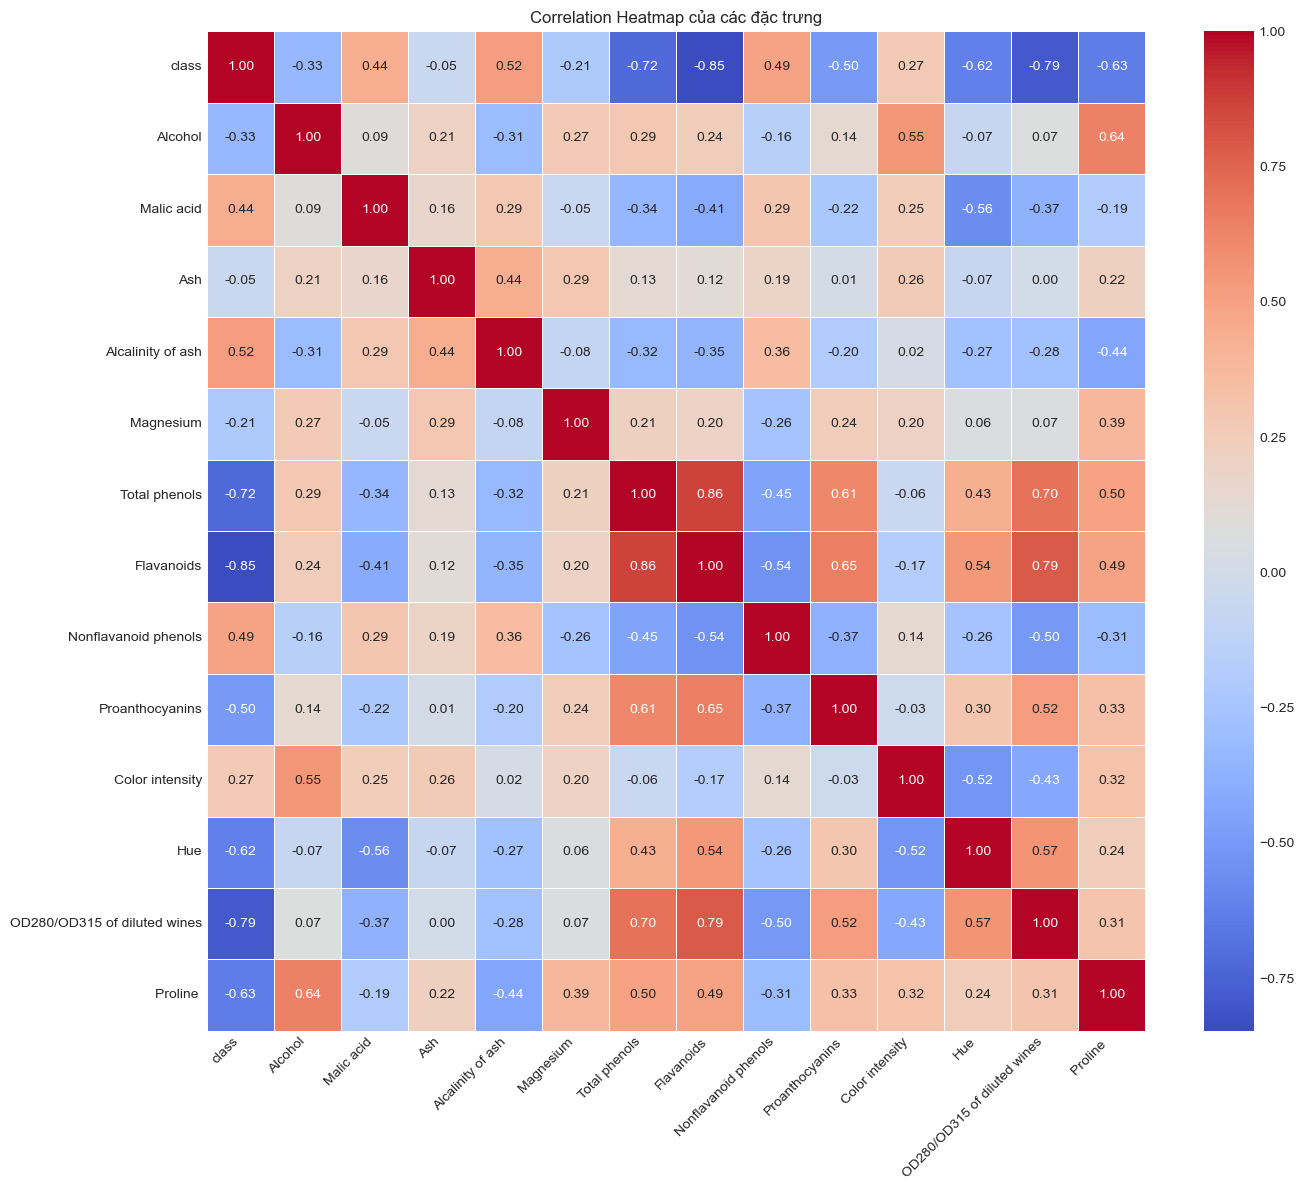

In [120]:
# Biểu đồ tương quan giữa các đặc trưng
plt.figure(figsize=(14, 12))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt=".2f")
plt.title('Correlation Heatmap của các đặc trưng')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

- Sử dụng biểu đồ histogram để trực quan hóa phân phối của các đặc trưng trong tập dữ liệu.

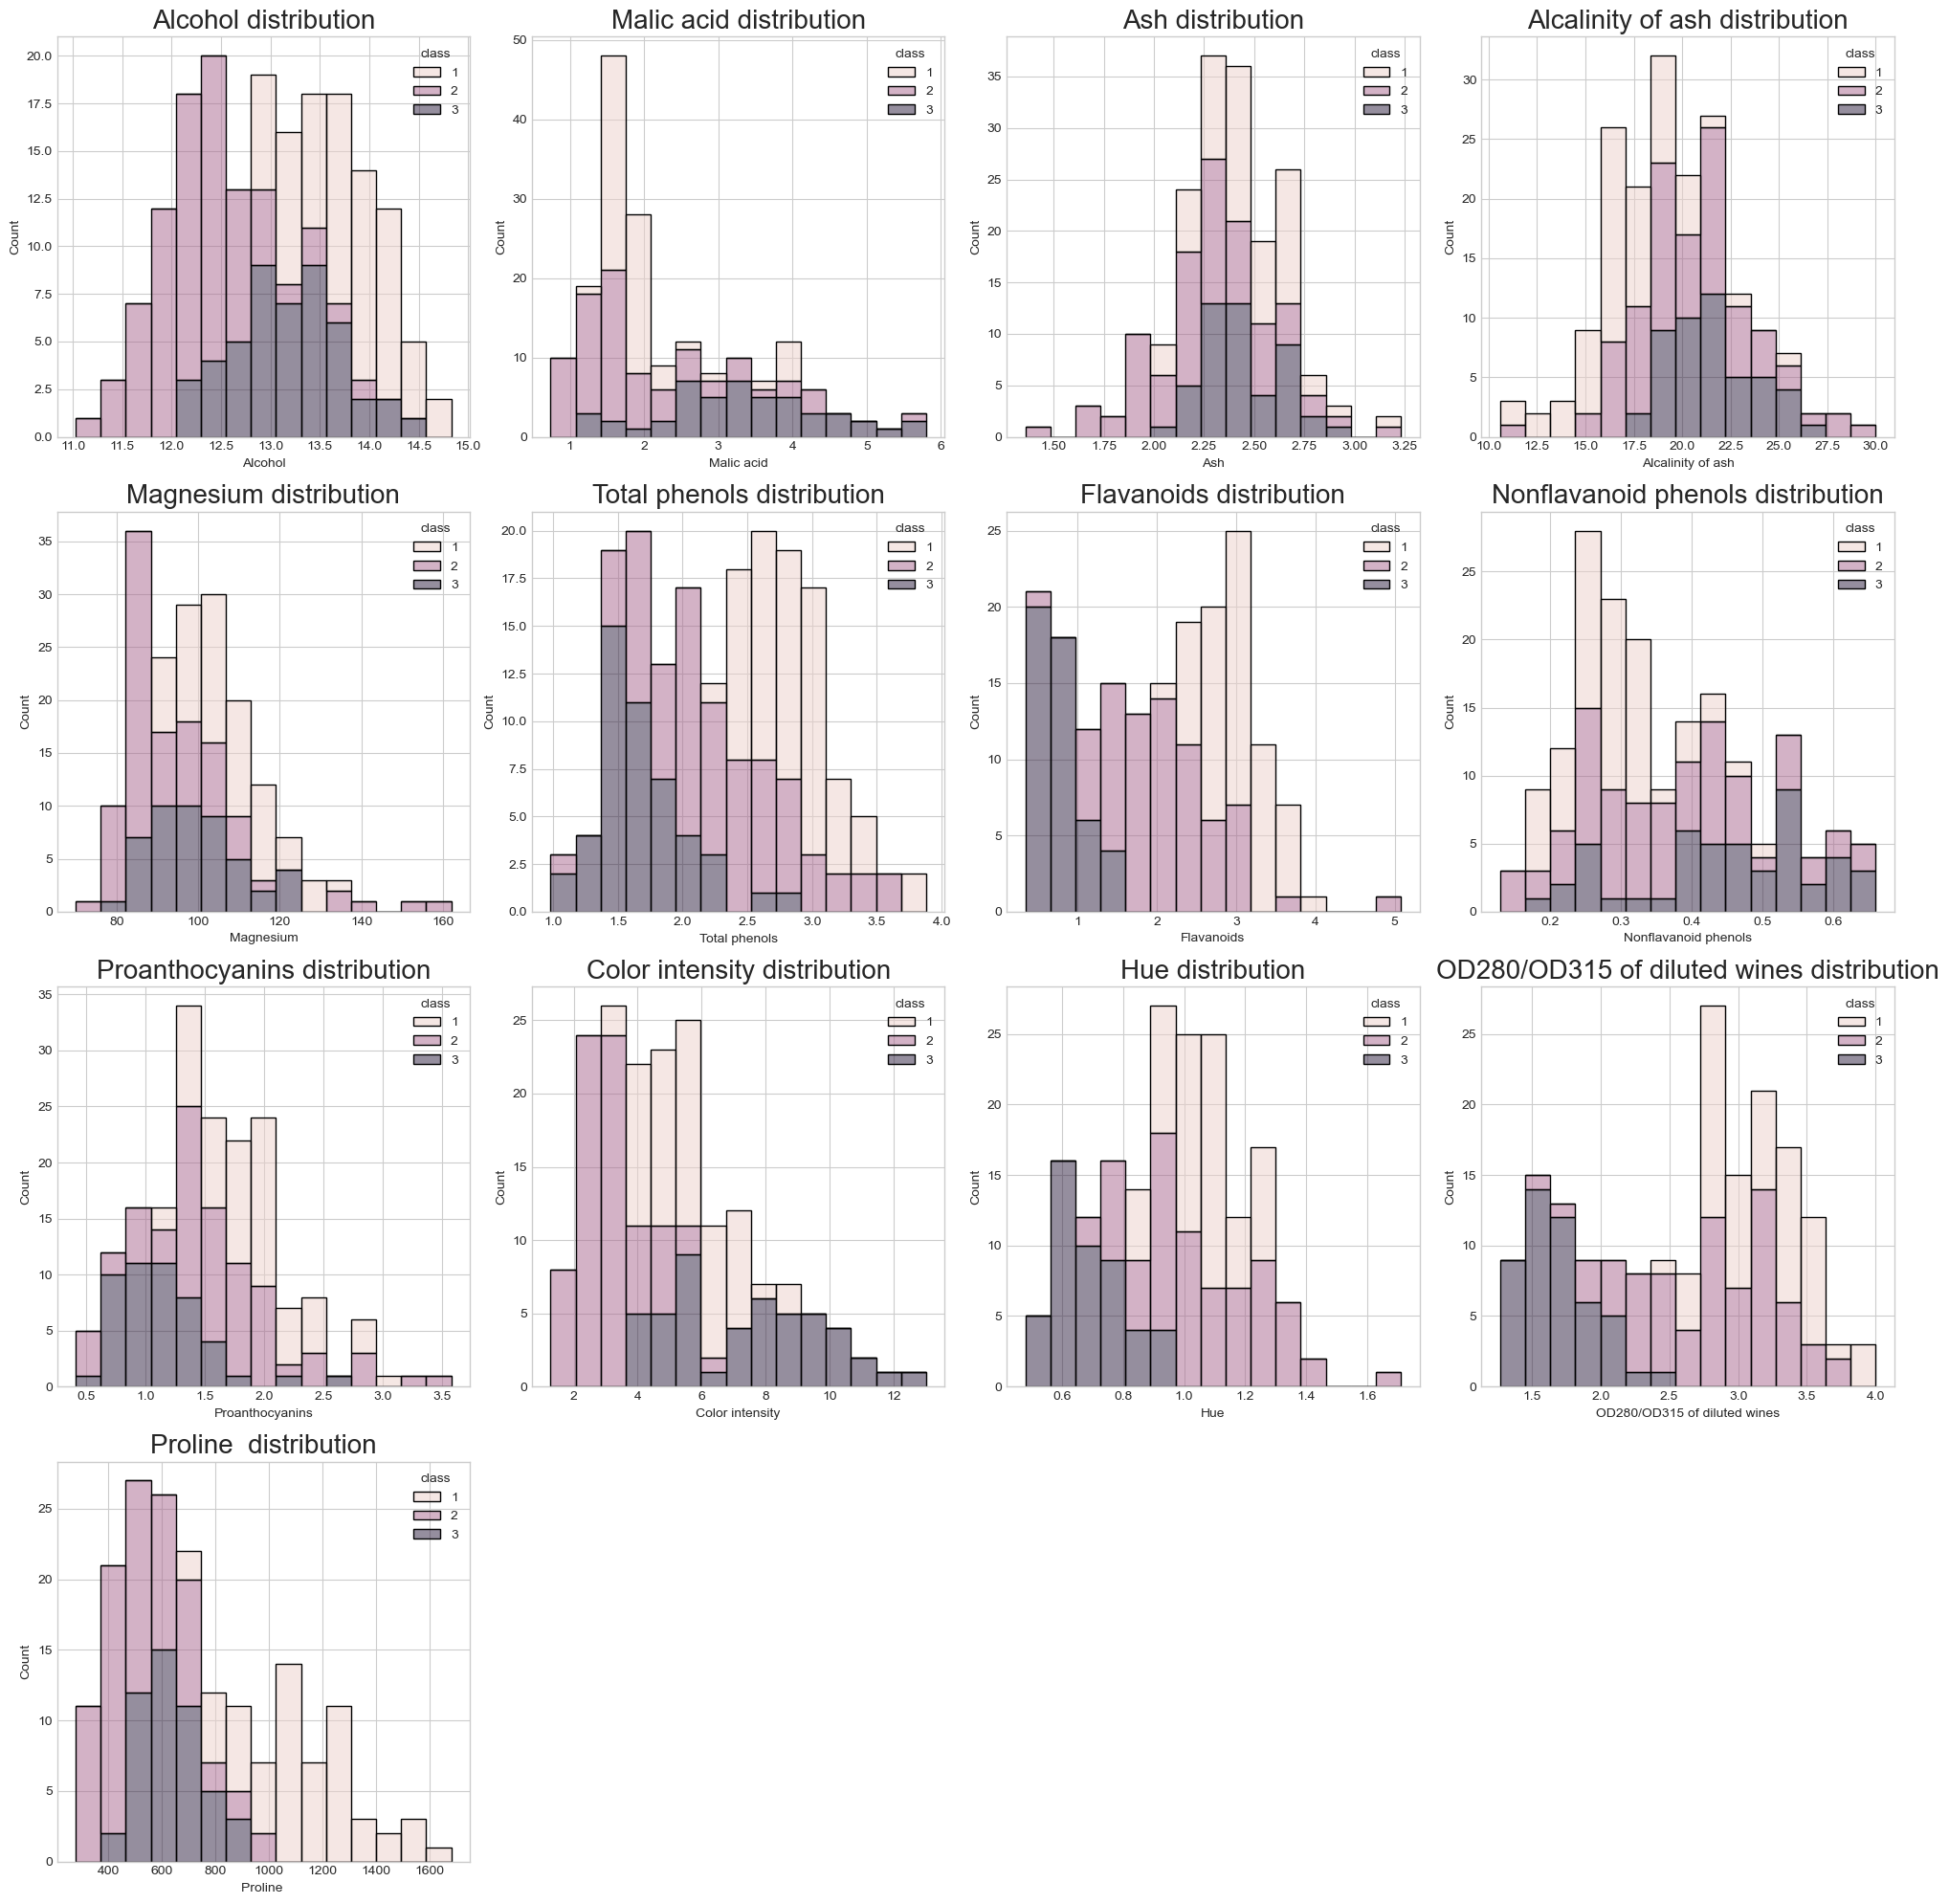

In [121]:
# Vẽ histograms cho các đặc trưng
plt.figure(figsize=(20, 20))
i = 1
for col in df.drop(columns='class'):
    plt.subplot(4, 4, i)
    sns.histplot(data=df, x=col, hue='class', bins=15, multiple="stack", alpha=.5)
    plt.title(col + " distribution", fontsize=20)
    i = i + 1

plt.tight_layout()
plt.show()

- Sử dụng biểu đồ phân bố số lượng mẫu theo lớp để trực quan hóa phân phối của các lớp trong tập dữ liệu.

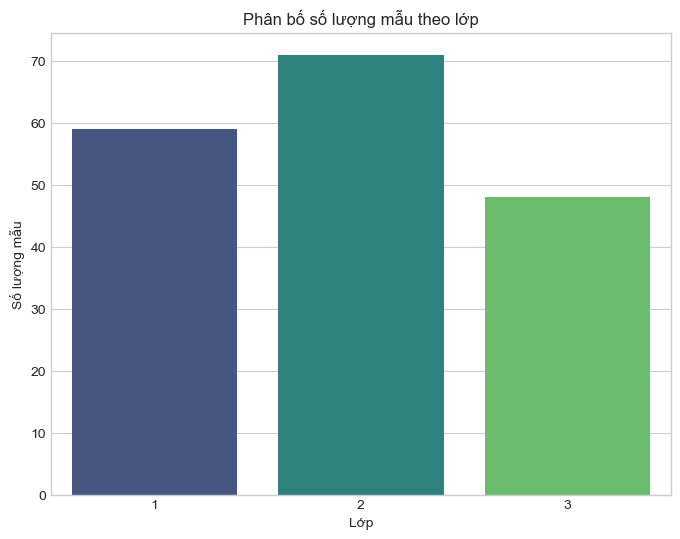

In [122]:
# Biểu đồ phân bố lớp
plt.figure(figsize=(8, 6))
sns.countplot(x='class', data=df, palette='viridis')
plt.title('Phân bố số lượng mẫu theo lớp')
plt.xlabel('Lớp')
plt.ylabel('Số lượng mẫu')
plt.show()

- Boxplot giúp quan sát sự khác biệt, độ phân tán và giá trị ngoại lệ của từng đặc trưng theo từng lớp.




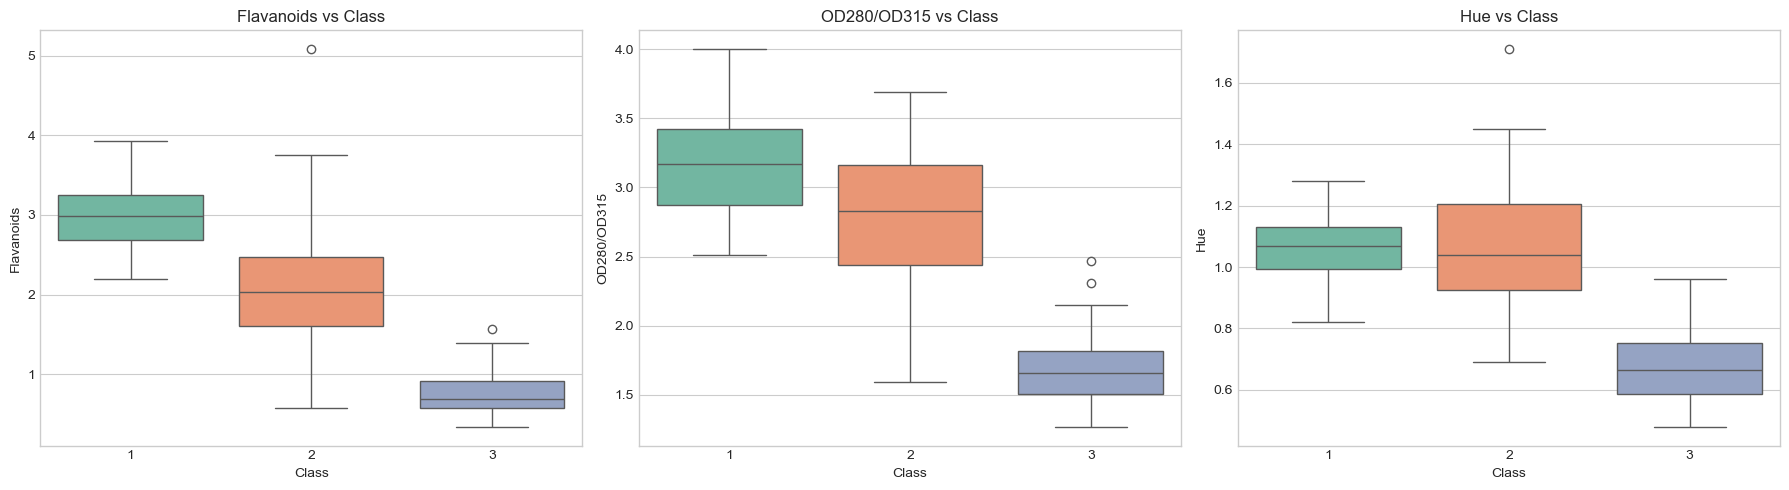

In [123]:
plt.figure(figsize=(18, 5))

# Biểu đồ 1 - Flavanoids
plt.subplot(1, 3, 1)
sns.boxplot(data=df, x="class", y="Flavanoids", palette='Set2')
plt.title("Flavanoids vs Class")
plt.xlabel("Class")
plt.ylabel("Flavanoids")

# Biểu đồ 2 - OD280/OD315
plt.subplot(1, 3, 2)
sns.boxplot(data=df, x="class", y="OD280/OD315 of diluted wines", palette='Set2')
plt.title("OD280/OD315 vs Class")
plt.xlabel("Class")
plt.ylabel("OD280/OD315")

# Biểu đồ 3 - Hue
plt.subplot(1, 3, 3)
sns.boxplot(data=df, x="class", y="Hue", palette='Set2')
plt.title("Hue vs Class")
plt.xlabel("Class")
plt.ylabel("Hue")

# Hiển thị tất cả
plt.tight_layout()
plt.show()

 Biểu đồ boxplot cho thấy sự xuất hiện của một số giá trị ngoại lệ trong các đặc trưng như Flavanoids, OD280/OD315 và Hue, đặc biệt ở class 2 và class 3. Những giá trị này có thể phản ánh các mẫu rượu có tính chất đặc biệt hoặc cần được kiểm tra thêm

- Sử dụng pairplot để trực quan hóa mối quan hệ giữa các đặc trưng trong tập dữ liệu.

<Figure size 1500x1000 with 0 Axes>

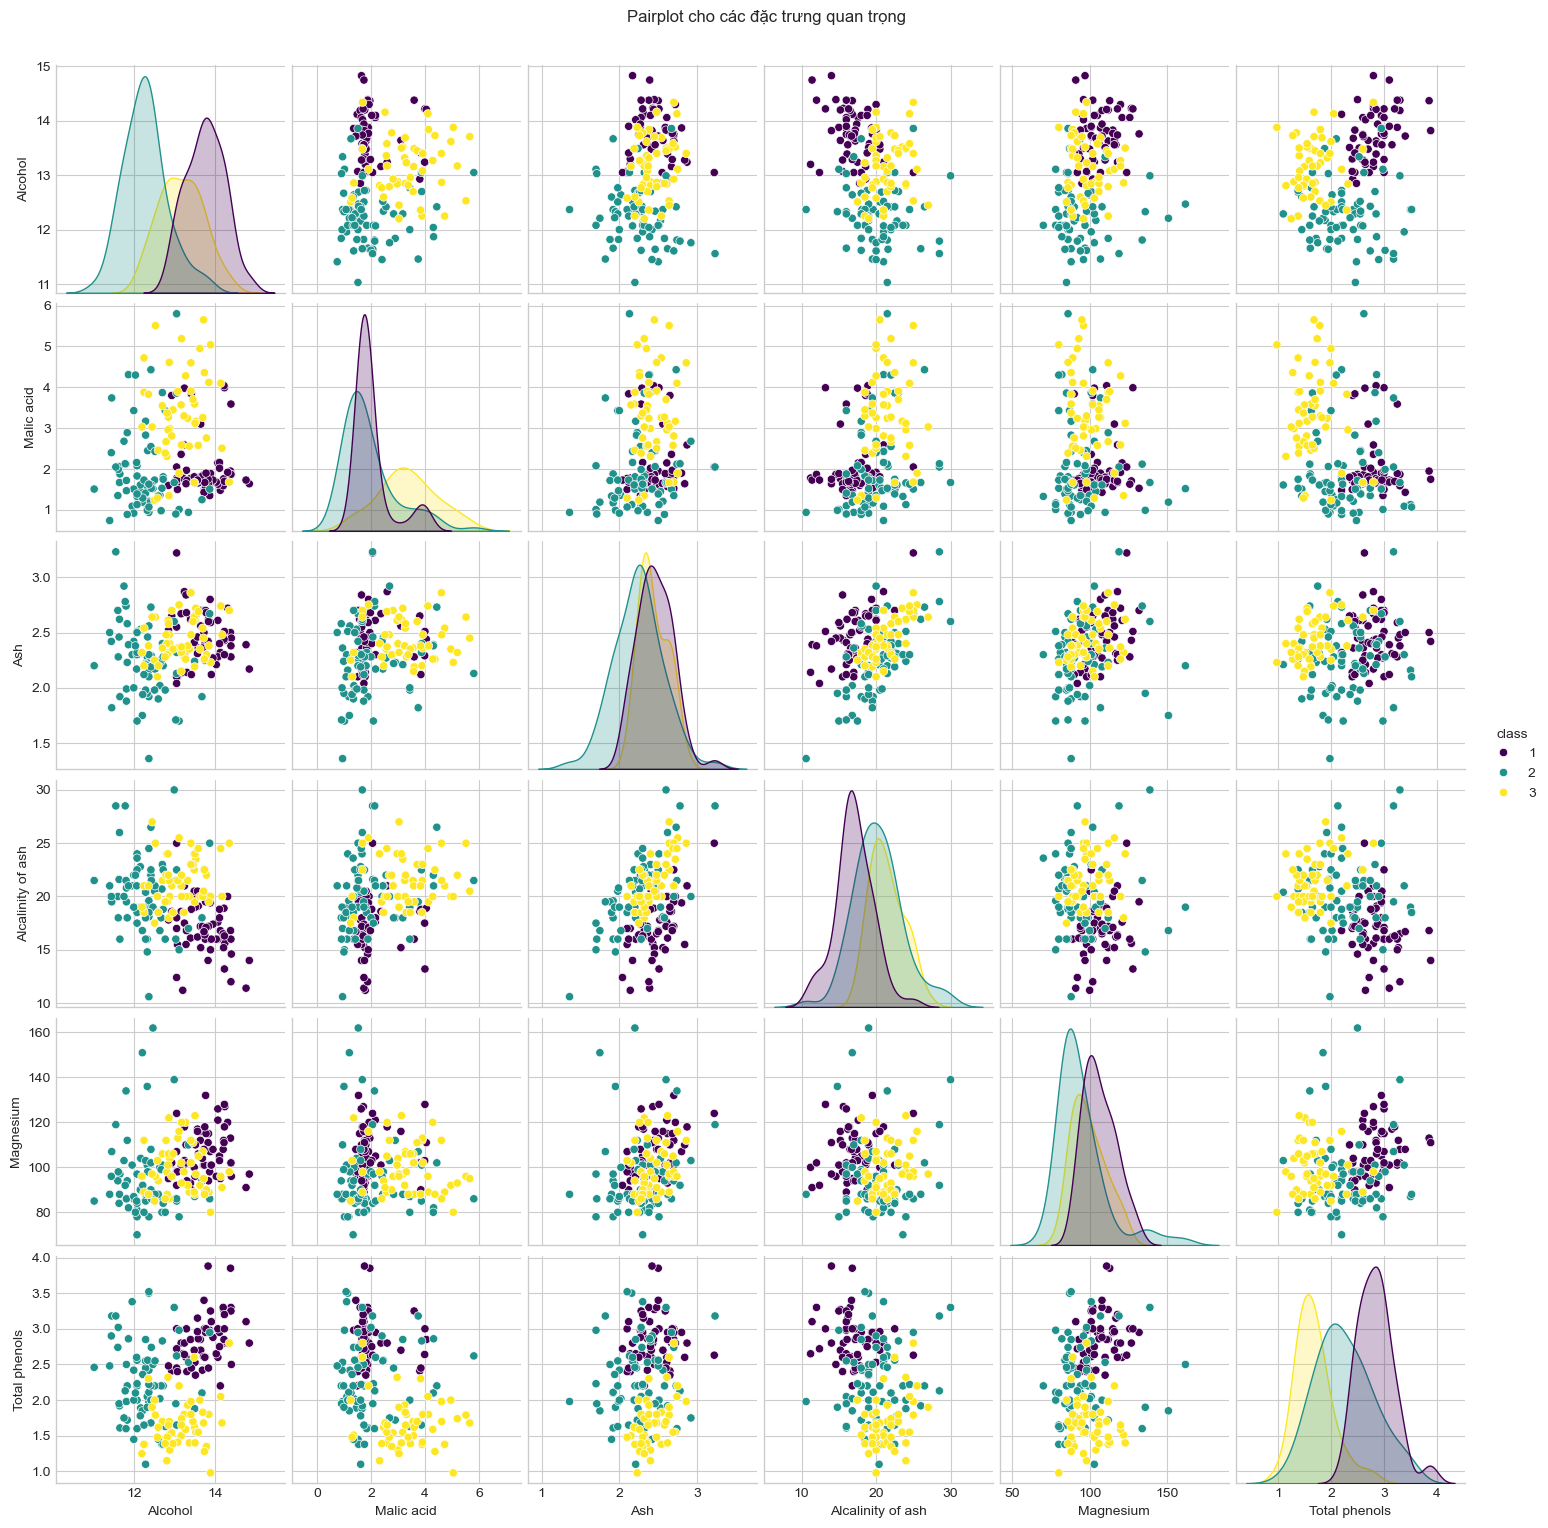

In [124]:
# Pairplot cho một số đặc trưng quan trọng
important_features = ['Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 'Magnesium', 'Total phenols']
plt.figure(figsize=(15, 10))
sns.pairplot(df, vars=important_features, hue='class', palette='viridis', diag_kind='kde')
plt.suptitle('Pairplot cho các đặc trưng quan trọng', y=1.02)
plt.show()

Biểu đồ pairplot giúp trực quan hóa mối quan hệ giữa các đặc trưng quan trọng trong tập dữ liệu rượu vang. Thông qua các scatterplot và biểu đồ phân phối KDE, ta có thể đánh giá mức độ phân biệt giữa các lớp rượu dựa trên từng cặp đặc trưng, cũng như phát hiện các xu hướng tương quan hoặc phân cụm tự nhiên trong dữ liệu. Đây là bước phân tích tiền xử lý cần thiết nhằm lựa chọn đặc trưng phù hợp cho mô hình phân loại.

### 1.6 Chuẩn hóa dữ liệu


In [125]:
# Tách đặc trưng và nhãn
X = df.drop('class', axis=1)
y = df['class']

In [126]:
# Kiểm tra xem dữ liệu có cần chuẩn hóa không
# Thống kê mô tả
print("\nThống kê mô tả trước khi chuẩn hóa:\n")
print(X.describe().to_string())


Thống kê mô tả trước khi chuẩn hóa:

       Alcohol  Malic acid   Ash   Alcalinity of ash  Magnesium  Total phenols  Flavanoids  Nonflavanoid phenols  Proanthocyanins  Color intensity   Hue   OD280/OD315 of diluted wines  Proline 
count  178.00     178.00   178.00       178.00         178.00       178.00        178.00           178.00             178.00           178.00      178.00             178.00               178.00
mean    13.00       2.34     2.37        19.49          99.74         2.30          2.03             0.36               1.59             5.06        0.96               2.61               746.89
std      0.81       1.12     0.27         3.34          14.28         0.63          1.00             0.12               0.57             2.32        0.23               0.71               314.91
min     11.03       0.74     1.36        10.60          70.00         0.98          0.34             0.13               0.41             1.28        0.48               1.27              

In [127]:
# Chuẩn hóa dữ liệu sử dụng StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

In [128]:
print("\nThống kê mô tả sau khi chuẩn hóa với StandardScaler:")
print(X_scaled_df.describe())


Thống kê mô tả sau khi chuẩn hóa với StandardScaler:
       Alcohol  Malic acid   Ash   Alcalinity of ash  Magnesium  Total phenols  Flavanoids  Nonflavanoid phenols  Proanthocyanins  Color intensity   Hue   OD280/OD315 of diluted wines  Proline 
count  178.00     178.00   178.00       178.00         178.00       178.00        178.00           178.00             178.00           178.00      178.00             178.00              178.00 
mean    -0.00      -0.00    -0.00        -0.00          -0.00         0.00         -0.00             0.00              -0.00             0.00        0.00               0.00               -0.00 
std      1.00       1.00     1.00         1.00           1.00         1.00          1.00             1.00               1.00             1.00        1.00               1.00                1.00 
min     -2.43      -1.43    -3.68        -2.67          -2.09        -2.11         -1.70            -1.87              -2.07            -1.63       -2.09              -1.

### 1.7 So sánh tương quan sau khi chuẩn hóa


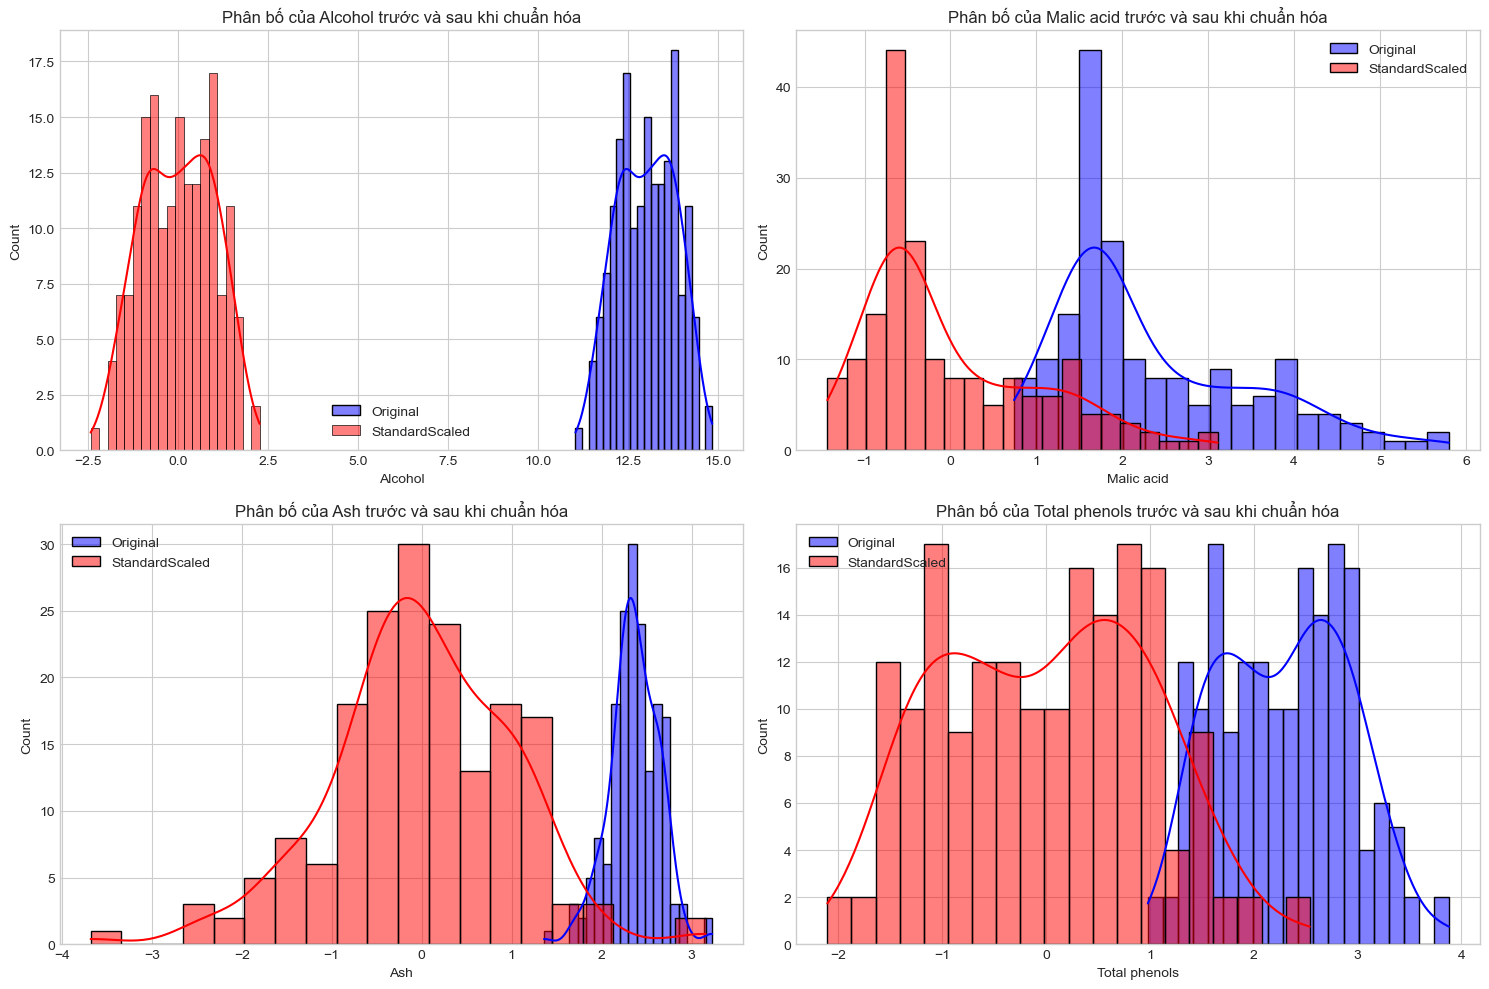

In [129]:
# Visualize một số đặc trưng sau khi chuẩn hóa
plt.figure(figsize=(15, 10))
feature_to_plot = ['Alcohol', 'Malic acid', 'Ash', 'Total phenols']

for i, feature in enumerate(feature_to_plot):
    plt.subplot(2, 2, i + 1)

    # Phân bố dữ liệu gốc
    sns.histplot(X[feature], bins=20, alpha=0.5, color='blue', label='Original', kde=True)

    # Phân bố dữ liệu sau khi chuẩn hóa StandardScaler
    sns.histplot(X_scaled_df[feature], bins=20, alpha=0.5, color='red', label='StandardScaled', kde=True)

    plt.title(f'Phân bố của {feature} trước và sau khi chuẩn hóa')
    plt.legend()

plt.tight_layout()
plt.show()


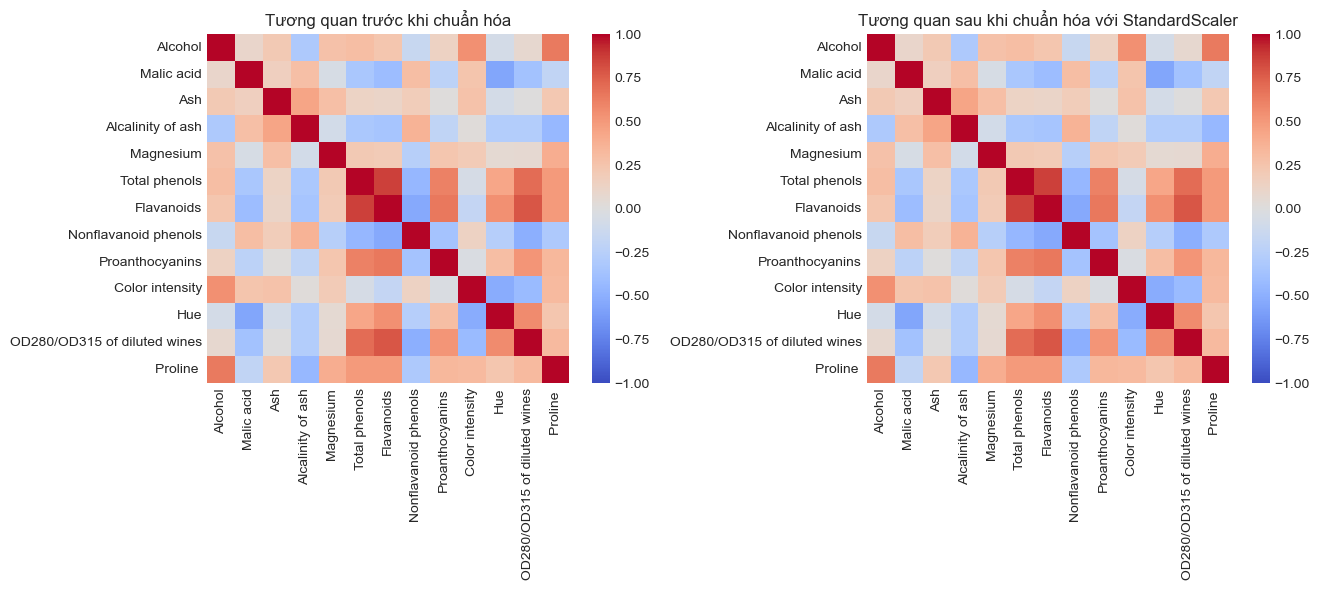


Kết luận và tóm tắt phần khám phá dữ liệu:
1. Dữ liệu không có giá trị null.
2. Dữ liệu có 178 mẫu với 13 đặc trưng.
3. Phân bố các lớp: {2: 71, 1: 59, 3: 48}
4. Chuẩn hóa dữ liệu với StandardScaler không ảnh hưởng đến tương quan giữa các đặc trưng.
5. Một số đặc trưng có tương quan cao với nhau.
6. Sự phân bố của các đặc trưng khác nhau giữa các lớp, cho thấy tiềm năng phân loại cao.


In [130]:
# So sánh tương quan trước và sau khi chuẩn hóa
plt.figure(figsize=(20, 6))

plt.subplot(1, 3, 1)
sns.heatmap(X.corr(), annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Tương quan trước khi chuẩn hóa')

plt.subplot(1, 3, 2)
sns.heatmap(X_scaled_df.corr(), annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Tương quan sau khi chuẩn hóa với StandardScaler')

plt.tight_layout()
plt.show()
print("\nKết luận và tóm tắt phần khám phá dữ liệu:")
print("1. Dữ liệu không có giá trị null.")
print("2. Dữ liệu có", len(df), "mẫu với", len(df.columns) - 1, "đặc trưng.")
print("3. Phân bố các lớp:", df['class'].value_counts().to_dict())
print("4. Chuẩn hóa dữ liệu với StandardScaler không ảnh hưởng đến tương quan giữa các đặc trưng.")
print("5. Một số đặc trưng có tương quan cao với nhau.")
print("6. Sự phân bố của các đặc trưng khác nhau giữa các lớp, cho thấy tiềm năng phân loại cao.")

## Bước 2: Xây dựng mô hình Machine Learning
---
1. Xây dựng mô hình Logistic Regression
2. Xây dựng mô hình Navie Bayes



### 2.1 Xây dựng mô hình Logistic Regression


In [131]:
# Sử dụng dữ liệu đã chuẩn hóa với StandardScaler
X = X_scaled_df
y = df['class']

In [132]:
# Chia dữ liệu thành tập huấn luyện và tập kiểm tra (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Số lượng mẫu huấn luyện: {X_train.shape[0]}")
print(f"Số lượng mẫu kiểm tra: {X_test.shape[0]}")
print(f"Phân bố lớp trong tập huấn luyện: {pd.Series(y_train).value_counts().to_dict()}")
print(f"Phân bố lớp trong tập kiểm tra: {pd.Series(y_test).value_counts().to_dict()}")

Số lượng mẫu huấn luyện: 142
Số lượng mẫu kiểm tra: 36
Phân bố lớp trong tập huấn luyện: {2: 57, 1: 47, 3: 38}
Phân bố lớp trong tập kiểm tra: {2: 14, 1: 12, 3: 10}


In [133]:
# Thiết lập mô hình Logistic Regression với các tham số đã chỉ định
lr_model = LogisticRegression(penalty='l2', solver='lbfgs', random_state=42, max_iter=1000)

In [134]:
# Huấn luyện mô hình trên tập huấn luyện
lr_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [135]:
# Dự đoán trên tập kiểm tra
y_pred_lr = lr_model.predict(X_test)

In [136]:
# Đánh giá mô hình
print("Đánh giá mô hình Logistic Regression:")
lr_accuracy = accuracy_score(y_test, y_pred_lr)
print(f"Accuracy: {lr_accuracy:.4f}")

Đánh giá mô hình Logistic Regression:
Accuracy: 0.9722


### 2.2 Xây dựng mô hình Naive Bayes


In [137]:
# Thiết lập mô hình Gaussian Naive Bayes
nb_model = GaussianNB()

In [138]:
# Huấn luyện mô hình trên tập huấn luyện
nb_model.fit(X_train, y_train)

GaussianNB()

In [139]:
# Dự đoán trên tập kiểm tra
y_pred_nb = nb_model.predict(X_test)

In [140]:
# Đánh giá mô hình
print("Đánh giá mô hình Naive Bayes:")
nb_accuracy = accuracy_score(y_test, y_pred_nb)
print(f"Accuracy: {nb_accuracy:.6f}")

Đánh giá mô hình Naive Bayes:
Accuracy: 0.972222


# Bước 3: Huấn luyện và phân tích lỗi
---
Huấn luyện và phân tích lỗi cho cả 2 mô hình, gồm có:
- Đánh giá Accuracy, Precision, Recall, F1.
- Vẽ Confusion Matrix.
- So sánh hiệu năng giữa 2 mô hình

In [141]:
# Tạo các mô hình cơ bản
lr_model = LogisticRegression(penalty='l2', solver='lbfgs', random_state=42, max_iter=1000)
nb_model = GaussianNB()

# Đánh giá theo F1-Score
models = {
    "Logistic Regression": lr_model,
    "Naive Bayes": nb_model
}


--- Model: Logistic Regression ---

🔍 Báo cáo phân loại - Logistic Regression:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        12
           2       0.93      1.00      0.97        14
           3       1.00      0.90      0.95        10

    accuracy                           0.97        36
   macro avg       0.98      0.97      0.97        36
weighted avg       0.97      0.97      0.97        36

Accuracy:  0.9722
Precision: 0.9741 (weighted)
Recall:    0.9722 (weighted)
F1-Score:  0.9720 (weighted)


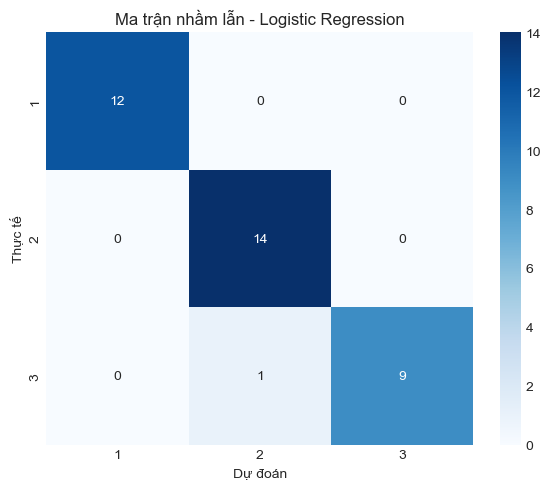


--- Model: Naive Bayes ---

🔍 Báo cáo phân loại - Naive Bayes:
              precision    recall  f1-score   support

           1       0.92      1.00      0.96        12
           2       1.00      0.93      0.96        14
           3       1.00      1.00      1.00        10

    accuracy                           0.97        36
   macro avg       0.97      0.98      0.97        36
weighted avg       0.97      0.97      0.97        36

Accuracy:  0.9722
Precision: 0.9744 (weighted)
Recall:    0.9722 (weighted)
F1-Score:  0.9723 (weighted)


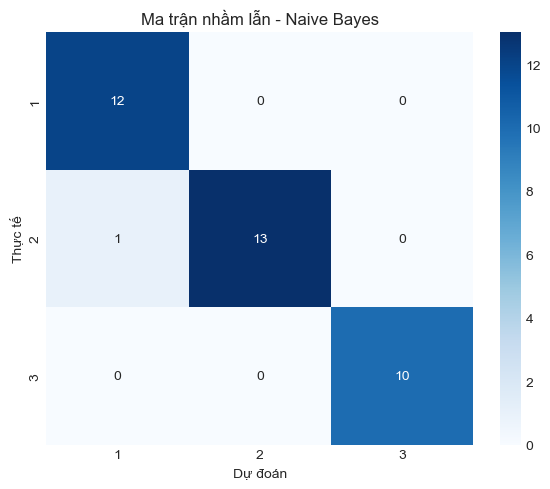

In [142]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def show_evaluation(y_true, y_pred, model_name, class_labels):
    print(f"\n🔍 Báo cáo phân loại - {model_name}:")
    print(classification_report(y_true, y_pred))

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f} (weighted)")
    print(f"Recall:    {recall:.4f} (weighted)")
    print(f"F1-Score:  {f1:.4f} (weighted)")

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels,
                yticklabels=class_labels)
    plt.xlabel('Dự đoán')
    plt.ylabel('Thực tế')
    plt.title(f'Ma trận nhầm lẫn - {model_name}')
    plt.tight_layout()
    plt.show()

# Giả sử models chứa các mô hình đã khởi tạo, df là dataframe chứa cột 'class' (label)
results_f1 = {}
class_labels = sorted(df['class'].unique())

for name, model in models.items():
    # Huấn luyện mô hình
    model.fit(X_train, y_train)

    # Dự đoán
    y_pred = model.predict(X_test)

    # Lưu F1-score weighted
    f1 = f1_score(y_test, y_pred, average='weighted')
    results_f1[name] = f1

    print(f"\n--- Model: {name} ---")
    show_evaluation(y_test, y_pred, name, class_labels)


In [143]:
# Đánh giá chéo (Cross-validation)
cv_results_f1 = {}
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cv_results_lr = cross_val_score(lr_model, X, y, cv=kfold, scoring='accuracy')
print(f"\nĐộ chính xác trung bình đối với Logistic Regression qua 5-fold cross-validation: {cv_results_lr.mean():.4f} ± {cv_results_lr.std():.4f}")
cv_results_nb = cross_val_score(nb_model, X, y, cv=kfold, scoring='accuracy')
print(f"\nĐộ chính xác trung bình đối với Navie Bayes qua 5-fold cross-validation: {cv_results_nb.mean():.4f} ± {cv_results_nb.std():.4f}")
# Kiểm tra Cross-validation với F1-Score
for name, model in models.items():
    cv_f1 = cross_val_score(model, X_scaled_df, y, cv=kfold, scoring='f1_weighted')
    cv_results_f1[name] = (cv_f1.mean(), cv_f1.std())


Độ chính xác trung bình đối với Logistic Regression qua 5-fold cross-validation: 0.9887 ± 0.0138

Độ chính xác trung bình đối với Navie Bayes qua 5-fold cross-validation: 0.9830 ± 0.0228


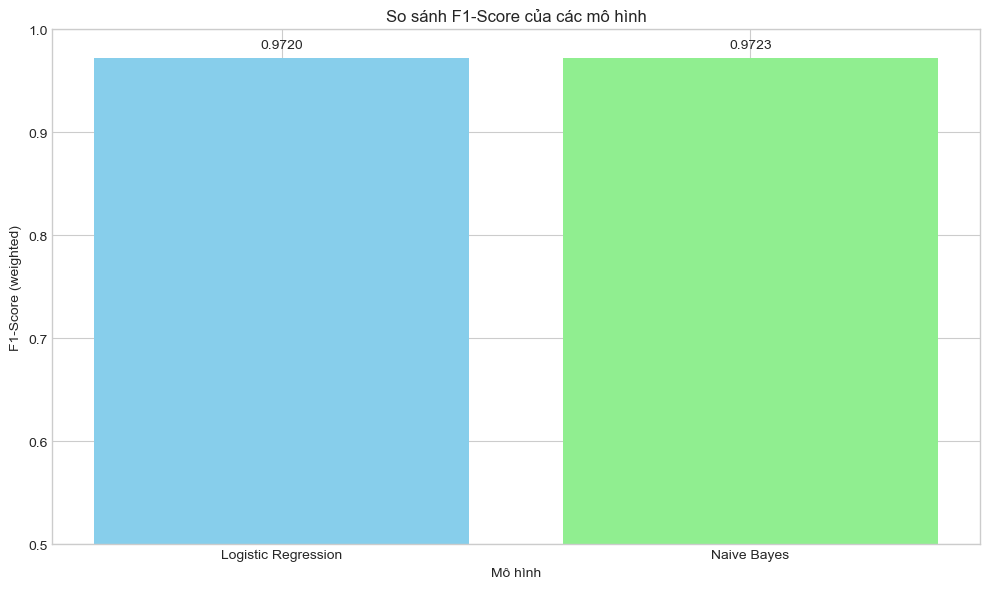

In [144]:
# Vẽ biểu đồ so sánh F1-Score
plt.figure(figsize=(10, 6))
plt.bar(results_f1.keys(), results_f1.values(), color=['skyblue', 'lightgreen'])
plt.ylim(0.5, 1.0)
plt.xlabel('Mô hình')
plt.ylabel('F1-Score (weighted)')
plt.title('So sánh F1-Score của các mô hình')

# Thêm giá trị F1-Score lên biểu đồ
for i, (name, f1) in enumerate(results_f1.items()):
    plt.text(i, f1 + 0.01, f"{f1:.4f}", ha='center')

plt.tight_layout()
plt.show()

In [145]:
print("\nKết luận và tóm tắt về mô hình:")
print(
    f"1. Mô hình Logistic Regression đạt accuracy: {lr_accuracy:.4f} (CV: {cv_results_lr.mean():.4f} ± {cv_results_lr.std():.4f})")
print(
    f"2. Mô hình Naive Bayes đạt accuracy: {nb_accuracy:.4f} (CV: {cv_results_nb.mean():.4f} ± {cv_results_nb.std():.4f})")

if lr_accuracy > nb_accuracy:
    print("3. Logistic Regression cho kết quả tốt hơn Naive Bayes trên tập test.")
elif nb_accuracy > lr_accuracy:
    print("3. Naive Bayes cho kết quả tốt hơn Logistic Regression trên tập test.")
else:
    print("3. Cả hai mô hình cho kết quả tương đương nhau trên tập test.")

if cv_results_lr.mean() > cv_results_nb.mean():
    print("4. Logistic Regression có độ ổn định tốt hơn qua cross-validation.")
elif cv_results_nb.mean() > cv_results_lr.mean():
    print("4. Naive Bayes có độ ổn định tốt hơn qua cross-validation.")
else:
    print("4. Cả hai mô hình có độ ổn định tương đương qua cross-validation.")


Kết luận và tóm tắt về mô hình:
1. Mô hình Logistic Regression đạt accuracy: 0.9722 (CV: 0.9887 ± 0.0138)
2. Mô hình Naive Bayes đạt accuracy: 0.9722 (CV: 0.9830 ± 0.0228)
3. Cả hai mô hình cho kết quả tương đương nhau trên tập test.
4. Logistic Regression có độ ổn định tốt hơn qua cross-validation.


# Bước 4: Tối ưu hóa mô hình


In [146]:
# Pipeline để kết hợp tiền xử lý và mô hình
pipe_lr = Pipeline([
    ('classifier', LogisticRegression(random_state=42, max_iter=2000))
])

In [147]:
# Tham số cần tìm kiếm
param_grid_lr = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear', 'saga']
}

In [148]:
# Grid Search để tìm tham số tối ưu
grid_lr = GridSearchCV(
    pipe_lr,
    param_grid_lr,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1
)

# Huấn luyện và tìm tham số tối ưu
grid_lr.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('classifier',
                                        LogisticRegression(max_iter=2000,
                                                           random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__C': [0.01, 0.1, 1, 10, 100],
                         'classifier__penalty': ['l1', 'l2'],
                         'classifier__solver': ['liblinear', 'saga']},
             scoring='f1_weighted', verbose=1)

In [149]:
# Hiển thị kết quả
print(f"\nTham số tốt nhất cho Logistic Regression: {grid_lr.best_params_}")
print(f"F1-Score tốt nhất trên tập validation: {grid_lr.best_score_:.4f}")

# Sử dụng mô hình tốt nhất để dự đoán
best_lr = grid_lr.best_estimator_
y_pred_lr_best = best_lr.predict(X_test)
lr_best_f1 = f1_score(y_test, y_pred_lr_best, average='weighted')

print("\nKết quả trên tập test với mô hình Logistic Regression tốt nhất:")
print(f"F1-Score: {lr_best_f1:.4f}")
print(classification_report(y_test, y_pred_lr_best))


Tham số tốt nhất cho Logistic Regression: {'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'saga'}
F1-Score tốt nhất trên tập validation: 0.9932

Kết quả trên tập test với mô hình Logistic Regression tốt nhất:
F1-Score: 1.0000
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        12
           2       1.00      1.00      1.00        14
           3       1.00      1.00      1.00        10

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36



In [150]:
nb_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', GaussianNB())
])


In [151]:
# Thử nghiệm với GaussianNB và var_smoothing
nb_param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
}

In [152]:
from sklearn.model_selection import StratifiedKFold

# Phân tích Naive Bayes
print("🔍 Tối ưu hóa var_smoothing cho Naive Bayes...")
grid_nb = GridSearchCV(
    nb_pipeline,
    {'classifier__var_smoothing': nb_param_grid['var_smoothing']},
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='f1_weighted',
    n_jobs=-1
)
grid_nb.fit(X_train, y_train)

🔍 Tối ưu hóa var_smoothing cho Naive Bayes...


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('classifier', GaussianNB())]),
             n_jobs=-1,
             param_grid={'classifier__var_smoothing': [1e-09, 1e-08, 1e-07,
                                                       1e-06, 1e-05]},
             scoring='f1_weighted')

In [153]:
print(f"✅ Tham số tốt nhất cho NB: {grid_nb.best_params_}")
print(f"✅ F1-Score tốt nhất (CV): {grid_nb.best_score_:.4f}")

# Đánh giá trên tập test
best_nb = grid_nb.best_estimator_
y_pred_nb_best = best_nb.predict(X_test)
nb_best_f1 = f1_score(y_test, y_pred_nb_best, average='weighted')

nb_metrics = {
    'accuracy': accuracy_score(y_test, y_pred_nb_best),
    'f1_weighted': f1_score(y_test, y_pred_nb_best, average='weighted'),
    'f1_macro': f1_score(y_test, y_pred_nb_best, average='macro'),
    'precision': precision_score(y_test, y_pred_nb_best, average='weighted'),
    'recall': recall_score(y_test, y_pred_nb_best, average='weighted')
}

print(f"\n📊 KẾT QUẢ TRÊN TẬP TEST:")
for metric, value in nb_metrics.items():
    print(f"   {metric.upper()}: {value:.4f}")

print(f"\n📋 CLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred_nb_best))


✅ Tham số tốt nhất cho NB: {'classifier__var_smoothing': 1e-09}
✅ F1-Score tốt nhất (CV): 0.9724

📊 KẾT QUẢ TRÊN TẬP TEST:
   ACCURACY: 0.9722
   F1_WEIGHTED: 0.9723
   F1_MACRO: 0.9743
   PRECISION: 0.9744
   RECALL: 0.9722

📋 CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           1       0.92      1.00      0.96        12
           2       1.00      0.93      0.96        14
           3       1.00      1.00      1.00        10

    accuracy                           0.97        36
   macro avg       0.97      0.98      0.97        36
weighted avg       0.97      0.97      0.97        36



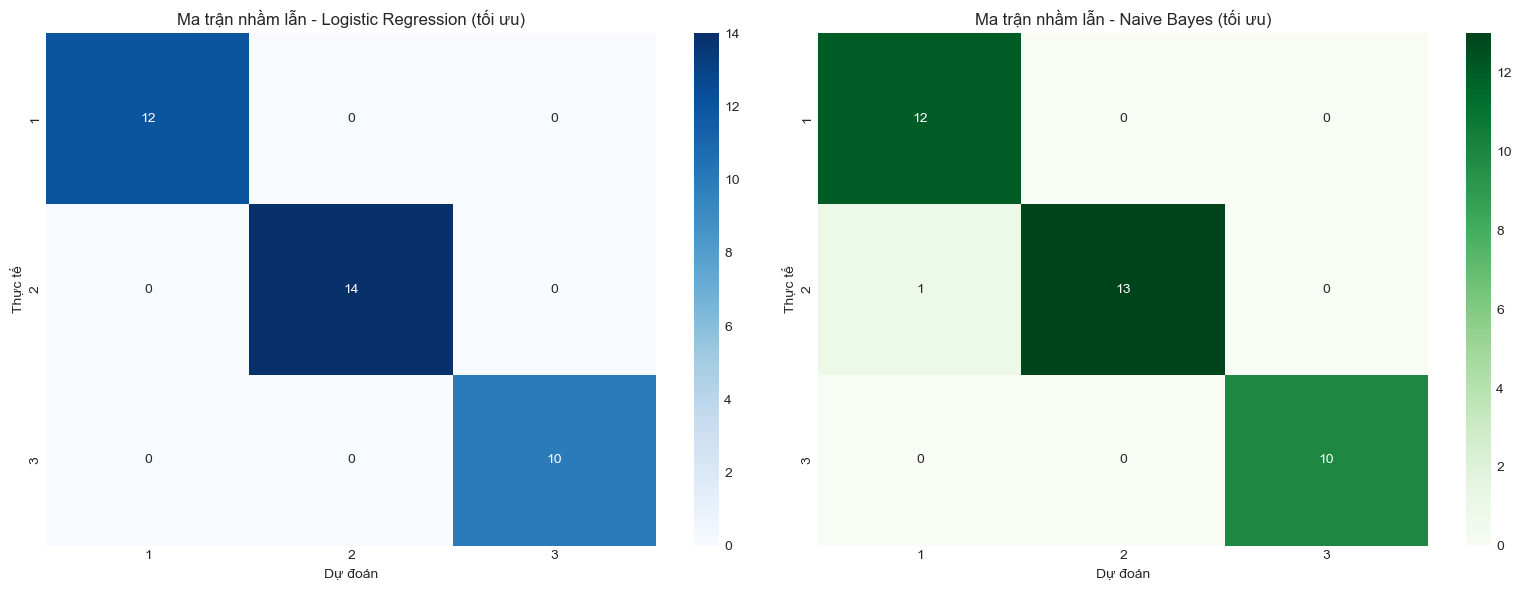

In [154]:
# Vẽ ma trận nhầm lẫn
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Ma trận nhầm lẫn cho Logistic Regression
cm_lr = confusion_matrix(y_test, y_pred_lr_best)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=sorted(y_test.unique()),
            yticklabels=sorted(y_test.unique()))
axes[0].set_xlabel('Dự đoán')
axes[0].set_ylabel('Thực tế')
axes[0].set_title('Ma trận nhầm lẫn - Logistic Regression (tối ưu)')

# Ma trận nhầm lẫn cho Naive Bayes
cm_nb = confusion_matrix(y_test, y_pred_nb_best)
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=sorted(y_test.unique()),
            yticklabels=sorted(y_test.unique()))
axes[1].set_xlabel('Dự đoán')
axes[1].set_ylabel('Thực tế')
axes[1].set_title('Ma trận nhầm lẫn - Naive Bayes (tối ưu)')

plt.tight_layout()
plt.show()


--- So sánh kết quả sau tối ưu hóa ---


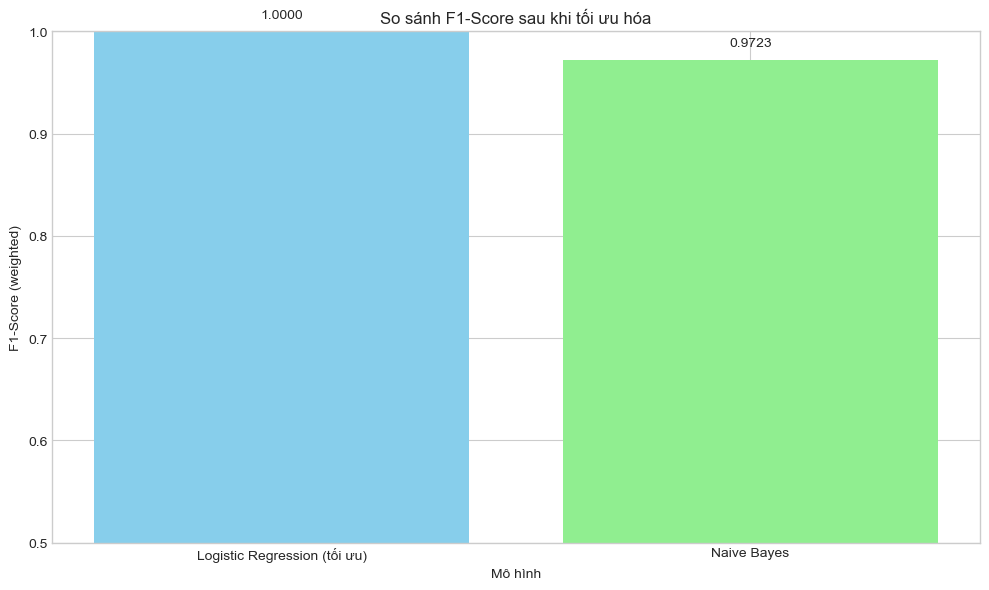

In [155]:
# So sánh kết quả sau khi tối ưu hóa
print("\n--- So sánh kết quả sau tối ưu hóa ---")
models_optimized = ['Logistic Regression (tối ưu)', 'Naive Bayes']
f1_scores = [lr_best_f1, nb_best_f1]

plt.figure(figsize=(10, 6))
bars = plt.bar(models_optimized, f1_scores, color=['skyblue', 'lightgreen'])
plt.ylim(0.5, 1.0)
plt.xlabel('Mô hình')
plt.ylabel('F1-Score (weighted)')
plt.title('So sánh F1-Score sau khi tối ưu hóa')

# Thêm giá trị F1-Score lên biểu đồ
for bar, f1 in zip(bars, f1_scores):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2., height + 0.01,
             f'{f1:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

## BƯỚC 5: TRIỂN KHAI MÔ HÌNH
---
### Lưu các mô hình sau tối ưu

In [156]:
# Lưu các mô hình tốt nhất
import joblib

In [157]:
# Lưu mô hình Logistic Regression tốt nhất
joblib.dump(best_lr, 'best_logistic_regression_model.pkl')

# Lưu mô hình Naive Bayes
joblib.dump(best_nb, 'naive_bayes_model.pkl')

# Lưu bộ StandardScaler để sử dụng khi dự đoán mẫu mới
joblib.dump(scaler, 'standard_scaler.pkl')

print("\nĐã lưu các mô hình vào file:")
print("- best_logistic_regression_model.pkl")
print("- naive_bayes_model.pkl")
print("- standard_scaler.pkl")


Đã lưu các mô hình vào file:
- best_logistic_regression_model.pkl
- naive_bayes_model.pkl
- standard_scaler.pkl


### Viết chương trình dự đoán rượu dựa vào thông số hóa học người dùng cung cấp
- Class được định nghĩa thực hiện yêu cầu từ người dùng

In [158]:
# =============================================================================
# GIAO DIỆN DỰ ĐOÁN LOẠI RƯỢU CHO JUPYTER NOTEBOOK
# =============================================================================

import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, clear_output, HTML
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
import warnings
warnings.filterwarnings('ignore')

class WineModelPredictor:
    """
    Lớp dự đoán loại rượu tối ưu cho Jupyter Notebook với widgets
    """
    def __init__(self):
        self.lr_model = None
        self.nb_model = None
        self.feature_names = [
            'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash',
            'Magnesium', 'Total phenols', 'Flavanoids', 'Nonflavanoid phenols',
            'Proanthocyanins', 'Color intensity', 'Hue',
            'OD280/OD315 of diluted wines', 'Proline'
        ]
        self.feature_ranges = {
            'Alcohol': (11.0, 15.0),
            'Malic acid': (0.7, 6.0),
            'Ash': (1.4, 3.3),
            'Alcalinity of ash': (10.6, 30.0),
            'Magnesium': (70, 162),
            'Total phenols': (0.98, 4.0),
            'Flavanoids': (0.34, 5.08),
            'Nonflavanoid phenols': (0.13, 0.66),
            'Proanthocyanins': (0.41, 3.58),
            'Color intensity': (1.28, 13.0),
            'Hue': (0.48, 1.71),
            'OD280/OD315 of diluted wines': (1.27, 4.0),
            'Proline': (278, 1680)
        }
        self.model_info = None
        self.input_widgets = {}
        self.output_widget = None
        self.wine_classes = {0: 'Class 0', 1: 'Class 1', 2: 'Class 2'}

    def load_models(self, lr_path='best_logistic_regression_model.pkl',
                   nb_path='naive_bayes_model.pkl',
                   results_path='model_comparison_results.pkl'):
        """Load các mô hình đã được huấn luyện"""
        try:
            print("🔄 Đang tải các mô hình...")
            self.lr_model = joblib.load(lr_path)
            self.nb_model = joblib.load(nb_path)
            self.model_info = joblib.load(results_path)
            print("✅ Đã tải thành công các mô hình!")
            self.display_model_info()
            return True
        except FileNotFoundError as e:
            print(f"❌ Không tìm thấy file: {e}")
            print("💡 Chạy code huấn luyện trước hoặc sử dụng phương thức demo!")
            return False
        except Exception as e:
            print(f"❌ Lỗi: {e}")
            return False

    def display_model_info(self):
        """Hiển thị thông tin mô hình"""
        if not self.model_info:
            return

        lr_info = self.model_info['logistic_regression']
        nb_info = self.model_info['naive_bayes']

        html_content = f"""
        <div style="background: linear-gradient(135deg, #8B0000, #DC143C); padding: 20px; border-radius: 15px; margin: 15px 0; color: white;">
            <h3>🍷 THÔNG TIN MÔ HÌNH DỰ ĐOÁN LOẠI RƯỢU</h3>
            <div style="display: flex; gap: 20px; margin-top: 15px;">
                <div style="flex: 1; background-color: rgba(255,255,255,0.1); padding: 15px; border-radius: 10px; backdrop-filter: blur(10px);">
                    <h4>🔵 Logistic Regression</h4>
                    <p><strong>F1-Score:</strong> {lr_info['metrics']['f1_weighted']:.4f}</p>
                    <p><strong>Accuracy:</strong> {lr_info['metrics']['accuracy']:.4f}</p>
                    <p><strong>Tham số:</strong> {lr_info['best_params']}</p>
                </div>
                <div style="flex: 1; background-color: rgba(255,255,255,0.1); padding: 15px; border-radius: 10px; backdrop-filter: blur(10px);">
                    <h4>🟢 Naive Bayes</h4>
                    <p><strong>F1-Score:</strong> {nb_info['metrics']['f1_weighted']:.4f}</p>
                    <p><strong>Accuracy:</strong> {nb_info['metrics']['accuracy']:.4f}</p>
                    <p><strong>Tham số:</strong> {nb_info['best_params']}</p>
                </div>
            </div>
        </div>
        """
        display(HTML(html_content))

    def setup_demo_models(self):
        """Thiết lập mô hình demo với wine dataset"""
        from sklearn.datasets import load_wine
        from sklearn.model_selection import train_test_split
        from sklearn.linear_model import LogisticRegression
        from sklearn.naive_bayes import GaussianNB
        from sklearn.pipeline import Pipeline
        from sklearn.preprocessing import StandardScaler

        print("🍷 Tạo mô hình demo với Wine Dataset...")

        # Load wine dataset
        wine_data = load_wine()
        X, y = wine_data.data, wine_data.target
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Tạo và huấn luyện mô hình
        self.lr_model = Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', LogisticRegression(random_state=42, max_iter=1000))
        ])

        self.nb_model = Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', GaussianNB())
        ])

        self.lr_model.fit(X_train, y_train)
        self.nb_model.fit(X_train, y_train)

        # Cập nhật tên classes
        self.wine_classes = {0: 'Class 0', 1: 'Class 1', 2: 'Class 2'}

        print("✅ Đã tạo mô hình demo với Wine Dataset thành công!")
        return True

    def create_input_widgets(self):
        """Tạo widgets để nhập 13 đặc trưng của rượu"""
        self.input_widgets = {}

        for feature in self.feature_names:
            min_val, max_val = self.feature_ranges[feature]
            default_val = (min_val + max_val) / 2

            self.input_widgets[feature] = widgets.FloatText(
                value=round(default_val, 2),
                description=f'{feature}:',
                style={'description_width': '200px'},
                layout=widgets.Layout(width='350px'),
                step=0.01
            )

        # Nút dự đoán
        self.predict_button = widgets.Button(
            description='🍷 Dự đoán loại rượu',
            button_style='danger',
            layout=widgets.Layout(width='250px', height='50px'),
            style={'font_weight': 'bold'}
        )

        self.predict_button.on_click(self.on_predict_click)

        # Nút reset
        self.reset_button = widgets.Button(
            description='🔄 Reset',
            button_style='warning',
            layout=widgets.Layout(width='100px', height='50px')
        )

        self.reset_button.on_click(self.on_reset_click)

        # Widget hiển thị kết quả
        self.output_widget = widgets.Output()

        return self.input_widgets

    def display_input_interface(self):
        """Hiển thị giao diện nhập liệu cho 13 đặc trưng"""
        if not self.input_widgets:
            self.create_input_widgets()

        # Header
        header = widgets.HTML("""
        <div style="background: linear-gradient(135deg, #722F37, #C73E1D);
                    color: white; padding: 25px; border-radius: 15px; text-align: center; margin-bottom: 25px;
                    box-shadow: 0 8px 32px rgba(0,0,0,0.3);">
            <h2>🍷 DỰ ĐOÁN LOẠI RƯỢU VỚI MACHINE LEARNING</h2>
            <p style="font-size: 16px; margin-top: 10px;">Nhập 13 đặc trưng hóa học để dự đoán loại rượu</p>
            <p style="font-size: 14px; opacity: 0.9;">Sử dụng Logistic Regression và Naive Bayes</p>
        </div>
        """)

        # Hướng dẫn và thông tin về features
        feature_info = widgets.HTML("""
        <div style="background-color: #FFF8DC; padding: 15px; border-radius: 10px; margin-bottom: 20px; border-left: 5px solid #DAA520;">
            <h4>📖 Thông tin về các đặc trưng:</h4>
            <div style="display: grid; grid-template-columns: repeat(2, 1fr); gap: 10px; font-size: 13px;">
                <div><strong>Alcohol:</strong> Độ cồn (%)</div>
                <div><strong>Color intensity:</strong> Cường độ màu sắc</div>
                <div><strong>Malic acid:</strong> Axit malic (g/L)</div>
                <div><strong>Hue:</strong> Sắc độ</div>
                <div><strong>Ash:</strong> Tro (g/L)</div>
                <div><strong>OD280/OD315:</strong> Tỷ lệ quang học</div>
                <div><strong>Alcalinity of ash:</strong> Độ kiềm của tro</div>
                <div><strong>Proline:</strong> Proline (mg/L)</div>
                <div><strong>Magnesium:</strong> Magie (mg/L)</div>
                <div><strong>Total phenols:</strong> Tổng phenol</div>
                <div><strong>Flavanoids:</strong> Flavanoid</div>
                <div><strong>Nonflavanoid phenols:</strong> Phenol không phải flavanoid</div>
                <div><strong>Proanthocyanins:</strong> Proanthocyanin</div>
            </div>
        </div>
        """)

        # Tạo layout cho 13 inputs (3 cột)
        input_rows = []
        for i in range(0, len(self.feature_names), 3):
            features_in_row = self.feature_names[i:i+3]
            widgets_in_row = [self.input_widgets[feature] for feature in features_in_row]

            # Thêm placeholder nếu không đủ 3 widgets
            while len(widgets_in_row) < 3:
                widgets_in_row.append(widgets.HTML(""))

            row = widgets.HBox(widgets_in_row, layout=widgets.Layout(margin='5px 0'))
            input_rows.append(row)

        # Buttons
        button_row = widgets.HBox([
            self.predict_button,
            self.reset_button
        ], layout=widgets.Layout(justify_content='center', margin='20px 0'))

        # Container chính
        main_container = widgets.VBox([
            header,
            feature_info,
            widgets.HTML("<h3 style='color: #722F37;'>📝 Nhập các đặc trưng hóa học:</h3>"),
            *input_rows,
            button_row,
            self.output_widget
        ])

        display(main_container)

    def on_reset_click(self, button):
        """Reset tất cả giá trị về mặc định"""
        for feature in self.feature_names:
            min_val, max_val = self.feature_ranges[feature]
            default_val = (min_val + max_val) / 2
            self.input_widgets[feature].value = round(default_val, 2)

        with self.output_widget:
            clear_output()
            print("🔄 Đã reset tất cả giá trị về mặc định!")

    def on_predict_click(self, button):
        """Xử lý khi nhấn nút dự đoán"""
        with self.output_widget:
            clear_output()

            # Lấy dữ liệu từ widgets
            data = {}
            for feature, widget in self.input_widgets.items():
                data[feature] = widget.value

            # Kiểm tra dữ liệu hợp lệ
            if self.validate_input(data):
                self.predict_and_display(data)

    def validate_input(self, data_dict):
        """Kiểm tra tính hợp lệ của dữ liệu đầu vào"""
        errors = []

        for feature, value in data_dict.items():
            min_val, max_val = self.feature_ranges[feature]
            if value < min_val * 0.5 or value > max_val * 2:  # Cho phép một chút flexibility
                errors.append(f"⚠️ {feature}: {value:.2f} (khuyến nghị: {min_val:.1f}-{max_val:.1f})")

        if errors:
            warning_html = f"""
            <div style="background-color: #fff3cd; border: 1px solid #ffeaa7; padding: 15px; border-radius: 8px; margin: 10px 0;">
                <h4 style="color: #856404;">⚠️ Cảnh báo về giá trị đầu vào:</h4>
                <ul style="color: #856404; margin: 10px 0;">
                    {''.join([f'<li>{error}</li>' for error in errors])}
                </ul>
                <p style="color: #856404; font-style: italic;">Kết quả dự đoán có thể không chính xác với các giá trị ngoài phạm vi thông thường.</p>
            </div>
            """
            display(HTML(warning_html))

        return True

    def predict_and_display(self, data_dict):
        """Dự đoán và hiển thị kết quả"""
        if not self.lr_model or not self.nb_model:
            print("❌ Chưa tải mô hình!")
            return

        # Chuyển đổi thành DataFrame với đúng thứ tự features
        df = pd.DataFrame([data_dict])

        # Đảm bảo thứ tự columns đúng với model
        if hasattr(self.lr_model, 'feature_names_in_'):
            df = df[self.lr_model.feature_names_in_]
        else:
            df = df[self.feature_names]

        # Dự đoán
        lr_pred = self.lr_model.predict(df)[0]
        nb_pred = self.nb_model.predict(df)[0]

        lr_proba = self.lr_model.predict_proba(df)[0]
        nb_proba = self.nb_model.predict_proba(df)[0]

        lr_classes = self.lr_model.classes_
        nb_classes = self.nb_model.classes_

        # Hiển thị kết quả đẹp
        self.display_beautiful_results(data_dict, lr_pred, nb_pred,
                                     lr_proba, nb_proba, lr_classes, nb_classes)

    def display_beautiful_results(self, input_data, lr_pred, nb_pred,
                                lr_proba, nb_proba, lr_classes, nb_classes):
        """Hiển thị kết quả đẹp mắt cho wine prediction"""

        # HTML cho input data (chỉ hiển thị một số key features)
        key_features = ['Alcohol', 'Total phenols', 'Flavanoids', 'Color intensity', 'Proline']
        input_html = "<div style='background: linear-gradient(135deg, #FFF8DC, #F5DEB3); padding: 15px; border-radius: 10px; margin: 15px 0; border-left: 5px solid #DAA520;'>"
        input_html += "<h4>🍷 Đặc trưng chính của mẫu rượu:</h4>"
        input_html += "<div style='display: grid; grid-template-columns: repeat(3, 1fr); gap: 10px;'>"
        for feature in key_features:
            if feature in input_data:
                input_html += f"<div><strong>{feature}:</strong> {input_data[feature]:.2f}</div>"
        input_html += "</div></div>"

        # Kết quả dự đoán
        lr_confidence = max(lr_proba)
        nb_confidence = max(nb_proba)

        # Tên loại rượu
        wine_names = {0: '🍷 Class 0 (Loại 1)', 1: '🍾 Class 1 (Loại 2)', 2: '🥂 Class 2 (Loại 3)'}

        results_html = f"""
        <div style="display: flex; gap: 20px; margin: 20px 0;">
            <div style="flex: 1; background: linear-gradient(135deg, #e3f2fd, #bbdefb); padding: 20px; border-radius: 15px; border-left: 5px solid #2196F3; box-shadow: 0 4px 15px rgba(33,150,243,0.3);">
                <h4>🔵 Logistic Regression</h4>
                <p><strong>🎯 Dự đoán:</strong> <span style="font-size: 20px; color: #1976D2;">{wine_names.get(lr_pred, f'Class {lr_pred}')}</span></p>
                <p><strong>🎲 Độ tin cậy:</strong> <span style="font-size: 16px; font-weight: bold;">{lr_confidence:.4f}</span></p>
                <div style="font-size: 13px; background-color: rgba(255,255,255,0.7); padding: 10px; border-radius: 5px; margin-top: 10px;">
                    <strong>📊 Xác suất các loại rượu:</strong><br>
                    {'<br>'.join([f"• {wine_names.get(cls, f'Class {cls}')}: {prob:.4f}" for cls, prob in zip(lr_classes, lr_proba)])}
                </div>
            </div>

            <div style="flex: 1; background: linear-gradient(135deg, #e8f5e8, #c8e6c8); padding: 20px; border-radius: 15px; border-left: 5px solid #4CAF50; box-shadow: 0 4px 15px rgba(76,175,80,0.3);">
                <h4>🟢 Naive Bayes</h4>
                <p><strong>🎯 Dự đoán:</strong> <span style="font-size: 20px; color: #388E3C;">{wine_names.get(nb_pred, f'Class {nb_pred}')}</span></p>
                <p><strong>🎲 Độ tin cậy:</strong> <span style="font-size: 16px; font-weight: bold;">{nb_confidence:.4f}</span></p>
                <div style="font-size: 13px; background-color: rgba(255,255,255,0.7); padding: 10px; border-radius: 5px; margin-top: 10px;">
                    <strong>📊 Xác suất các loại rượu:</strong><br>
                    {'<br>'.join([f"• {wine_names.get(cls, f'Class {cls}')}: {prob:.4f}" for cls, prob in zip(nb_classes, nb_proba)])}
                </div>
            </div>
        </div>
        """

        # So sánh và khuyến nghị
        if lr_pred == nb_pred:
            comparison = f"""
            <div style='background: linear-gradient(135deg, #d4edda, #c3e6cb); padding: 15px; border-radius: 10px; border-left: 5px solid #28a745; margin: 15px 0;'>
                <h4 style="color: #155724;">✅ Kết quả nhất quán!</h4>
                <p style="color: #155724; font-size: 16px;"><strong>Cả hai mô hình đều dự đoán:</strong> {wine_names.get(lr_pred, f'Class {lr_pred}')}</p>
            </div>
            """
        else:
            comparison = f"""
            <div style='background: linear-gradient(135deg, #fff3cd, #ffeaa7); padding: 15px; border-radius: 10px; border-left: 5px solid #ffc107; margin: 15px 0;'>
                <h4 style="color: #856404;">⚠️ Kết quả khác nhau:</h4>
                <p style="color: #856404;"><strong>Logistic Regression:</strong> {wine_names.get(lr_pred, f'Class {lr_pred}')}</p>
                <p style="color: #856404;"><strong>Naive Bayes:</strong> {wine_names.get(nb_pred, f'Class {nb_pred}')}</p>
            </div>
            """

        best_model = "Logistic Regression" if lr_confidence > nb_confidence else "Naive Bayes"
        best_confidence = max(lr_confidence, nb_confidence)
        best_pred = lr_pred if lr_confidence > nb_confidence else nb_pred

        if best_confidence > 0.9:
            confidence_level = "Rất cao 🌟"
            confidence_color = "#28a745"
        elif best_confidence > 0.7:
            confidence_level = "Cao 👍"
            confidence_color = "#17a2b8"
        elif best_confidence > 0.5:
            confidence_level = "Trung bình ⚡"
            confidence_color = "#ffc107"
        else:
            confidence_level = "Thấp ⚠️"
            confidence_color = "#dc3545"

        recommendation = f"""
        <div style="background: linear-gradient(135deg, #f8f9fa, #e9ecef); padding: 20px; border-radius: 15px; margin: 15px 0; border: 3px solid {confidence_color}; box-shadow: 0 6px 20px rgba(0,0,0,0.1);">
            <h4 style="color: #495057;">🏆 Khuyến nghị cuối cùng:</h4>
            <p><strong>🥇 Mô hình tin cậy nhất:</strong> <span style="color: {confidence_color}; font-weight: bold;">{best_model}</span></p>
            <p><strong>🍷 Loại rượu dự đoán:</strong> <span style="color: {confidence_color}; font-size: 18px; font-weight: bold;">{wine_names.get(best_pred, f'Class {best_pred}')}</span></p>
            <p><strong>📊 Độ tin cậy:</strong> <span style="color: {confidence_color}; font-weight: bold;">{best_confidence:.4f}</span></p>
            <p><strong>📈 Mức độ tin cậy:</strong> <span style="color: {confidence_color}; font-weight: bold; font-size: 16px;">{confidence_level}</span></p>
        </div>
        """

        # Hiển thị tất cả
        display(HTML(input_html + results_html + comparison + recommendation))

        # Vẽ biểu đồ xác suất
        self.plot_probabilities(lr_classes, lr_proba, nb_proba)

    def plot_probabilities(self, classes, lr_proba, nb_proba):
        """Vẽ biểu đồ so sánh xác suất cho wine prediction"""
        fig, ax = plt.subplots(figsize=(12, 7))

        wine_names = ['Class 0\n(Loại 1)', 'Class 1\n(Loại 2)', 'Class 2\n(Loại 3)']
        x = np.arange(len(classes))
        width = 0.35

        bars1 = ax.bar(x - width/2, lr_proba, width, label='Logistic Regression',
                      color='#2196F3', alpha=0.8, edgecolor='white', linewidth=2)
        bars2 = ax.bar(x + width/2, nb_proba, width, label='Naive Bayes',
                      color='#4CAF50', alpha=0.8, edgecolor='white', linewidth=2)

        ax.set_xlabel('Loại Rượu', fontsize=12, fontweight='bold')
        ax.set_ylabel('Xác Suất Dự Đoán', fontsize=12, fontweight='bold')
        ax.set_title('🍷 So Sánh Xác Suất Dự Đoán Loại Rượu', fontsize=14, fontweight='bold', pad=20)
        ax.set_xticks(x)
        ax.set_xticklabels(wine_names)
        ax.legend(fontsize=11)
        ax.set_ylim(0, 1.1)
        ax.grid(True, alpha=0.3)

        # Thêm giá trị lên bars
        for bars in [bars1, bars2]:
            for bar in bars:
                height = bar.get_height()
                ax.annotate(f'{height:.3f}',
                           xy=(bar.get_x() + bar.get_width() / 2, height),
                           xytext=(0, 3),
                           textcoords="offset points",
                           ha='center', va='bottom',
                           fontweight='bold')

        plt.style.use('default')
        plt.tight_layout()
        plt.show()

# =============================================================================
# PHƯƠNG THỨC SỬ DỤNG NHANH CHO WINE PREDICTION
# =============================================================================

def create_wine_prediction_interface():
    """Tạo giao diện dự đoán loại rượu"""
    predictor = WineModelPredictor()

    # Thử tải mô hình, nếu không được thì dùng demo
    if not predictor.load_models():
        predictor.setup_demo_models()

    # Tạo giao diện
    predictor.create_input_widgets()
    predictor.display_input_interface()

    return predictor

def create_wine_sliders():
    """Tạo sliders cho wine prediction"""
    predictor = WineModelPredictor()

    if not predictor.load_models():
        predictor.setup_demo_models()

    def predict_wine(**kwargs):
        data = {k: v for k, v in kwargs.items()}
        predictor.predict_and_display(data)

    # Tạo sliders cho từng feature với ranges thực tế
    sliders = {}
    for feature in predictor.feature_names:
        min_val, max_val = predictor.feature_ranges[feature]
        default_val = (min_val + max_val) / 2

        sliders[feature] = widgets.FloatSlider(
            value=default_val,
            min=min_val * 0.8,
            max=max_val * 1.2,
            step=(max_val - min_val) / 100,
            description=feature,
            style={'description_width': '200px'},
            layout=widgets.Layout(width='500px'),
            readout_format='.2f'
        )

    return interact(predict_wine, **sliders)

# =============================================================================
# HƯỚNG DẪN SỬ DỤNG CHO WINE PREDICTION
# =============================================================================

def show_wine_usage_guide():
    """Hiển thị hướng dẫn sử dụng cho wine prediction"""
    guide_html = """
    <div style="background: linear-gradient(135deg, #722F37, #C73E1D);
                color: white; padding: 25px; border-radius: 15px; margin: 20px 0; box-shadow: 0 8px 32px rgba(0,0,0,0.3);">
        <h2>🍷 HƯỚNG DẪN SỬ DỤNG WINE PREDICTION</h2>

        <h3>🚀 Cách 1: Giao diện Widgets (Khuyên dùng)</h3>
        <pre style="background-color: rgba(255,255,255,0.1); padding: 15px; border-radius: 8px; margin: 10px 0;">
# Tạo giao diện dự đoán loại rượu
predictor = create_wine_prediction_interface()
        </pre>

        <h3>🎚️ Cách 2: Sliders tương tác cho 13 đặc trưng</h3>
        <pre style="background-color: rgba(255,255,255,0.1); padding: 15px; border-radius: 8px; margin: 10px 0;">
# Tạo sliders để điều chỉnh 13 đặc trưng hóa học
create_wine_sliders()
        </pre>

        <h3>🔧 Cách 3: Sử dụng thủ công</h3>
        <pre style="background-color: rgba(255,255,255,0.1); padding: 15px; border-radius: 8px; margin: 10px 0;">
# Khởi tạo thủ công
predictor = WineModelPredictor()
predictor.load_models()  # hoặc predictor.setup_demo_models()
predictor.display_input_interface()
        </pre>

        <h3>🍷 Thông tin về 13 đặc trưng:</h3>
        <div style="background-color: rgba(255,255,255,0.1); padding: 15px; border-radius: 8px; margin: 10px 0;">
            <div style="display: grid; grid-template-columns: repeat(2, 1fr); gap: 10px; font-size: 14px;">
                <div><strong>1. Alcohol:</strong> Độ cồn (11.0-15.0%)</div>
                <div><strong>2. Malic acid:</strong> Axit malic (0.7-6.0 g/L)</div>
                <div><strong>3. Ash:</strong> Tro (1.4-3.3 g/L)</div>
                <div><strong>4. Alcalinity of ash:</strong> Độ kiềm của tro (10.6-30.0)</div>
                <div><strong>5. Magnesium:</strong> Magie (70-162 mg/L)</div>
                <div><strong>6. Total phenols:</strong> Tổng phenol (0.98-4.0)</div>
                <div><strong>7. Flavanoids:</strong> Flavanoid (0.34-5.08)</div>
                <div><strong>8. Nonflavanoid phenols:</strong> Phenol không phải flavanoid (0.13-0.66)</div>
                <div><strong>9. Proanthocyanins:</strong> Proanthocyanin (0.41-3.58)</div>
                <div><strong>10. Color intensity:</strong> Cường độ màu sắc (1.28-13.0)</div>
                <div><strong>11. Hue:</strong> Sắc độ (0.48-1.71)</div>
                <div><strong>12. OD280/OD315:</strong> Tỷ lệ quang học (1.27-4.0)</div>
                <div><strong>13. Proline:</strong> Proline (278-1680 mg/L)</div>
            </div>
        </div>

        <h3>🎯 Kết quả dự đoán:</h3>
        <ul style="font-size: 14px; line-height: 1.6;">
            <li><strong>Class 0 (Loại 1):</strong> Rượu vang loại 1</li>
            <li><strong>Class 1 (Loại 2):</strong> Rượu vang loại 2</li>
            <li><strong>Class 2 (Loại 3):</strong> Rượu vang loại 3</li>
        </ul>

        <h3>💡 Lưu ý quan trọng:</h3>
        <ul style="font-size: 14px; line-height: 1.6;">
            <li>Hệ thống sẽ cảnh báo nếu giá trị ngoài phạm vi thông thường</li>
            <li>Giao diện hiển thị so sánh giữa 2 mô hình ML</li>
            <li>Kết quả bao gồm độ tin cậy và khuyến nghị</li>
            <li>Tự động tạo biểu đồ trực quan cho xác suất</li>
            <li>Tương thích với Jupyter Notebook và Google Colab</li>
            <li>Nếu chưa có mô hình trained, sẽ tự động dùng Wine dataset demo</li>
        </ul>

        <h3>🔍 Ví dụ giá trị mẫu:</h3>
        <pre style="background-color: rgba(255,255,255,0.1); padding: 15px; border-radius: 8px; margin: 10px 0;">
# Mẫu rượu vang điển hình:
Alcohol: 13.2, Malic acid: 2.8, Ash: 2.2, Alcalinity of ash: 18.5
Magnesium: 112, Total phenols: 2.85, Flavanoids: 2.91, Nonflavanoid phenols: 0.24
Proanthocyanins: 2.61, Color intensity: 5.7, Hue: 1.04, OD280/OD315: 3.17, Proline: 1065
        </pre>
    </div>
    """
    display(HTML(guide_html))

# =============================================================================
# DEMO FUNCTION VỚI SAMPLE DATA
# =============================================================================

def demo_wine_prediction():
    """Demo nhanh với dữ liệu mẫu"""
    predictor = WineModelPredictor()

    if not predictor.load_models():
        predictor.setup_demo_models()

    # Dữ liệu mẫu
    sample_data = {
        'Alcohol': 13.2,
        'Malic acid': 2.8,
        'Ash': 2.2,
        'Alcalinity of ash': 18.5,
        'Magnesium': 112,
        'Total phenols': 2.85,
        'Flavanoids': 2.91,
        'Nonflavanoid phenols': 0.24,
        'Proanthocyanins': 2.61,
        'Color intensity': 5.7,
        'Hue': 1.04,
        'OD280/OD315 of diluted wines': 3.17,
        'Proline': 1065
    }

    print("🍷 Demo với dữ liệu mẫu:")
    print("=" * 50)
    predictor.predict_and_display(sample_data)

# =============================================================================
# QUICK START
# =============================================================================

print("🍷 Wine Prediction Interface đã sẵn sàng!")
print("=" * 50)
print("📖 show_wine_usage_guide()      # Xem hướng dẫn chi tiết")
print("🚀 create_wine_prediction_interface()  # Tạo giao diện chính")
print("🎚️ create_wine_sliders()        # Tạo sliders tương tác")
print("🎭 demo_wine_prediction()        # Xem demo nhanh")
print("=" * 50)

🍷 Wine Prediction Interface đã sẵn sàng!
📖 show_wine_usage_guide()      # Xem hướng dẫn chi tiết
🚀 create_wine_prediction_interface()  # Tạo giao diện chính
🎚️ create_wine_sliders()        # Tạo sliders tương tác
🎭 demo_wine_prediction()        # Xem demo nhanh


- Hàm nhập từ người dùng - Có thể nhập thông số cho một mẫu hoặc từ file .csv

In [159]:
# Cách 1: Giao diện chính (khuyên dùng)
create_wine_prediction_interface()

# Cách 2: Sliders tương tác
# create_wine_sliders()

# Cách 3: Xem demo nhanh
# demo_wine_prediction()

# Xem hướng dẫn
# show_wine_usage_guide()

🔄 Đang tải các mô hình...
❌ Lỗi: 
🍷 Tạo mô hình demo với Wine Dataset...
✅ Đã tạo mô hình demo với Wine Dataset thành công!


- Hoặc có thể chạy thử nhanh ví dụ sau:

# Bước 6: Kết luận

In [160]:
print("\n1. Ưu điểm của các mô hình đã sử dụng:")
print("   Logistic Regression:")
print("   - Hiệu suất cao với F1-Score tốt sau khi tối ưu hóa")
print("   - Mô hình đơn giản, dễ hiểu và giải thích")
print("   - Huấn luyện nhanh, phù hợp với tập dữ liệu nhỏ")
print("   - Cung cấp xác suất thuộc về các lớp")
print("   - Có thể xác định tầm quan trọng của các đặc trưng")
print("\n   Naive Bayes:")
print("   - Đơn giản, nhanh chóng trong việc huấn luyện và dự đoán")
print("   - Hoạt động tốt ngay cả với tập dữ liệu nhỏ")
print("   - Ít bị ảnh hưởng bởi điểm ngoại lệ (outliers)")
print("   - Phù hợp với dữ liệu đa lớp")
print("   - Ít tham số cần tinh chỉnh")

print("\n2. Nhược điểm của các mô hình đã sử dụng:")
print("   Logistic Regression:")
print("   - Giả định mối quan hệ tuyến tính giữa đặc trưng và log-odds")
print("   - Có thể gặp vấn đề với đặc trưng có tương quan cao")
print("   - Có thể không bắt được mối quan hệ phi tuyến tính phức tạp")
print("   - Nhạy cảm với mất cân bằng dữ liệu")
print("\n   Naive Bayes:")
print("   - Giả định mạnh về tính độc lập giữa các đặc trưng (thường không đúng trong thực tế)")
print("   - Có thể không hiệu quả khi đặc trưng có tương quan cao")
print("   - Khó xử lý với các đặc trưng liên tục có phân phối phức tạp")
print("   - Có thể có vấn đề với 'zero frequency' khi dữ liệu ít")

print("\n3. Đề xuất cải tiến:")
print("   - Sử dụng kỹ thuật chọn lọc đặc trưng (Feature Selection) để loại bỏ đặc trưng dư thừa")
print("   - Thử nghiệm với các mô hình phức tạp hơn như Random Forest, SVM, hoặc Neural Networks")
print("   - Áp dụng kỹ thuật tạo đặc trưng (Feature Engineering) để tạo ra các đặc trưng mới")
print("   - Sử dụng kỹ thuật Ensemble để kết hợp nhiều mô hình")
print("   - Thu thập thêm dữ liệu hoặc sử dụng kỹ thuật augmentation để tăng kích thước tập dữ liệu")
print("   - Áp dụng phương pháp tiếp cận Deep Learning nếu có thêm dữ liệu")
print("   - Tìm hiểu thêm về đặc trưng domain-specific trong lĩnh vực rượu để cải thiện mô hình")
print("   - Thực hiện phân tích lỗi chi tiết để hiểu lý do mô hình dự đoán sai")
print("   - Cân nhắc sử dụng các độ đo hiệu suất khác ngoài F1-Score để đánh giá đầy đủ hơn")


1. Ưu điểm của các mô hình đã sử dụng:
   Logistic Regression:
   - Hiệu suất cao với F1-Score tốt sau khi tối ưu hóa
   - Mô hình đơn giản, dễ hiểu và giải thích
   - Huấn luyện nhanh, phù hợp với tập dữ liệu nhỏ
   - Cung cấp xác suất thuộc về các lớp
   - Có thể xác định tầm quan trọng của các đặc trưng

   Naive Bayes:
   - Đơn giản, nhanh chóng trong việc huấn luyện và dự đoán
   - Hoạt động tốt ngay cả với tập dữ liệu nhỏ
   - Ít bị ảnh hưởng bởi điểm ngoại lệ (outliers)
   - Phù hợp với dữ liệu đa lớp
   - Ít tham số cần tinh chỉnh

2. Nhược điểm của các mô hình đã sử dụng:
   Logistic Regression:
   - Giả định mối quan hệ tuyến tính giữa đặc trưng và log-odds
   - Có thể gặp vấn đề với đặc trưng có tương quan cao
   - Có thể không bắt được mối quan hệ phi tuyến tính phức tạp
   - Nhạy cảm với mất cân bằng dữ liệu

   Naive Bayes:
   - Giả định mạnh về tính độc lập giữa các đặc trưng (thường không đúng trong thực tế)
   - Có thể không hiệu quả khi đặc trưng có tương quan cao
  